In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
from collections import deque
from typing import List, Tuple, Callable, Optional
np.random.seed(1234)
random.seed(1234)

# 🧬 Resolución del problema de las N-reinas mediante Algoritmos Genéticos (AG)

Este proyecto aborda la resolución del clásico problema de las N-reinas utilizando Algoritmos Genéticos (AG), una técnica inspirada en los procesos evolutivos de la naturaleza.

El objetivo del problema es colocar N reinas en un tablero de ajedrez de NxN de forma que ninguna pueda atacar a otra, es decir, que no compartan fila, columna ni diagonal. Aunque la solución puede encontrarse mediante enfoques clásicos como el backtracking, aquí se propone una alternativa basada en inteligencia artificial evolutiva, capaz de buscar soluciones eficientes incluso para valores grandes de N.

## 1. Parámetros iniciales:

### 1.1. Representación del individuo

En este proyecto, cada individuo de la población será representado mediante una **permutación de N números**, donde cada número indica la **fila** en la que se ubica una reina, y su posición en el vector representa la **columna** correspondiente.

Por ejemplo, el cromosoma:

(1 3 2 4)


se interpreta como:
- La reina de la **fila 1** está en la **columna 1**,
- La reina de la **fila 2** está en la **columna 3**,
- La reina de la **fila 3** está en la **columna 2**,
- La reina de la **fila 4** está en la **columna 4**.

Esta representación garantiza automáticamente que **no haya conflictos en columnas ni filas**, ya que cada número (fila) y cada posición (columna) del vector son únicos.  
Por lo tanto, la evaluación se centra exclusivamente en detectar **conflictos en diagonales**, lo que simplifica la función de aptitud.

### 1.2. Evaluación (función de aptitud / fitness)

En el problema de las N-reinas, el objetivo es colocar \( N \) reinas en un tablero de \( N x N \) de forma que ninguna de las reinas se ataque. Las reinas se atacan si están en la misma fila, columna o diagonal. La función de fitness que se presenta evalúa cuántas parejas de reinas no se atacan entre sí diagonalmente. Cuanto mayor sea el valor de fitness, mejor es la disposición de las reinas en el tablero.

La fórmula matemática para la función de fitness es la siguiente:

$$
\text{fitness}(\text{población}) = \sum_{i=1}^{n} \sum_{j=i+1}^{n} \left[ \left| \text{individuo}[i] - \text{individuo}[j] \right| == \left| i - j \right| \right]
$$


Para facilitar la programación del algoritmo, crearemos una clase para representar el cromosoma junto a la función de fitness:

In [2]:
def fitness(cromosoma: List[int]) -> int:
    """
    Calcula el valor de fitness de un cromosoma para el problema de las N-reinas.
    
    :param cromosoma: Una lista de enteros que representa la disposición de las reinas en el tablero.
    :return: Un valor entero que indica el fitness del cromosoma.
    """
    fitness = 0
    for i in range(len(cromosoma)):
        for j in range(i + 1, len(cromosoma)):
            fitness += (np.abs(cromosoma[i] - cromosoma[j]) == np.abs(i - j))
                    
    return fitness

In [3]:
class Individuo:
    def __init__(self, 
                 N_cromosoma: int, 
                 f_fitness: Callable[[List[int]], int], 
                 cromosoma: Optional[List[int]] = None) -> None:
        """
        Inicializa un individuo con un cromosoma aleatorio o proporcionado, y calcula su fitness.
        
        :param N_cromosoma: Número de reinas (tamaño del tablero).
        :param f_fitness: Función de fitness que evalúa un cromosoma.
        :param cromosoma: Una lista de enteros representando la disposición de las reinas. Si no se proporciona, se genera aleatoriamente.
        """
        self.N_cromosoma = N_cromosoma
        if cromosoma is None:
            # Genera un cromosoma aleatorio
            self.cromosoma = random.sample(range(N_cromosoma), N_cromosoma)
        else:
            self.cromosoma = cromosoma
        self.f_fitness = f_fitness
        # Calcula el fitness del individuo
        self.fitness = f_fitness(self.cromosoma)

    def mostrar_individuo(self) -> None:
        """
        Muestra el cromosoma y el fitness del individuo.
        """
        print("Cromosoma:", self.cromosoma)
        print("Fitness:", self.fitness)


Probamos la clase creada:

In [4]:
individuo = Individuo(N_cromosoma=4, f_fitness=fitness)
individuo.mostrar_individuo()

Cromosoma: [3, 0, 2, 1]
Fitness: 1


### 1.3. Representación y generación de la población:

En un algoritmo genético, la población representa el conjunto de posibles soluciones al problema que estamos tratando de resolver. Cada individuo dentro de la población es una solución candidata que será evaluada y, en función de su calidad (fitness), podrá reproducirse, mutar o ser reemplazada a lo largo de las generaciones.

En este caso, vamos a crear una **clase Población** que se encargará de representar y gestionar la población de individuos. Esta clase incluirá métodos para:

1. **Generar la población inicial**: Crearemos una población inicial de individuos de manera aleatoria, basándonos en las reglas del problema (en este caso, el problema de las N-reinas). Cada individuo representará una posible disposición de las reinas en el tablero.
   
2. **Evaluar la población**: Evaluaremos el fitness de cada individuo en la población utilizando la función de fitness definida anteriormente. Esto nos permitirá medir qué tan "buena" es cada solución en términos de su capacidad para resolver el problema de las N-reinas.

3. **Gestionar la población**: La clase también se encargará de gestionar la población a lo largo de las generaciones, permitiendo operaciones como la selección de progenitores, la reproducción (cruce) y la mutación.

Al crear esta clase, podemos abstraer la complejidad de manejar la población de manera organizada, facilitando la implementación y el mantenimiento del algoritmo genético.

### Objetivos:
- **Representar la población de individuos** de manera eficiente.
- **Gestionar las operaciones** de selección, cruce y mutación en la población a lo largo de las generaciones.
- **Evaluar el fitness** de los individuos y seleccionar a los mejores para la reproducción.

De esta manera, la clase Población servirá como el núcleo para las interacciones entre los individuos y las generaciones del algoritmo genético.


In [5]:
class Poblacion:
    def __init__(self, 
                 N_poblacion: int, 
                 N_cromosoma: int, 
                 f_fitness: Callable[[List[int]], int], 
                 individuos: Optional[List[Individuo]] = None) -> None:
        """
        Inicializa una población de individuos para el algoritmo genético.

        :param N_poblacion: Número de individuos en la población.
        :param N_cromosoma: Número de reinas (dimensión del cromosoma).
        :param f_fitness: Función de fitness que evalúa el cromosoma de cada individuo.
        :param individuos: Lista opcional de individuos. Si no se proporciona, se generará una población aleatoria.
        """
        self.N_poblacion = N_poblacion
        self.N_cromosoma = N_cromosoma
        # Inicializamos los individuos
        if individuos is None:
            self.individuos = [Individuo(N_cromosoma=N_cromosoma, f_fitness=f_fitness) 
                               for _ in range(N_poblacion)]
        else:
            self.individuos = individuos

        # Calculamos los fitness de la población
        self.fitness_poblacion = [individuo.fitness for individuo in self.individuos]
        self.fitness_medio = np.mean(self.fitness_poblacion)

    def mostrar_poblacion(self) -> None:
        """
        Muestra todos los individuos de la población con su cromosoma y su fitness.
        """
        for idx, individuo in enumerate(self.individuos):
            print(f"Individuo {idx}:")
            individuo.mostrar_individuo()
            print()


Probamos la clase creada:

In [6]:
poblacion = Poblacion(N_poblacion=5, N_cromosoma=4, f_fitness=fitness)
poblacion.mostrar_poblacion()

Individuo 0:
Cromosoma: [0, 2, 3, 1]
Fitness: 1

Individuo 1:
Cromosoma: [2, 0, 3, 1]
Fitness: 0

Individuo 2:
Cromosoma: [0, 1, 2, 3]
Fitness: 6

Individuo 3:
Cromosoma: [1, 0, 2, 3]
Fitness: 2

Individuo 4:
Cromosoma: [0, 2, 1, 3]
Fitness: 2



### 1.4. Selección de progenitores:

En los algoritmos genéticos, la selección de progenitores es un paso clave para generar nuevas soluciones a partir de la población actual. Se busca elegir a los individuos más aptos para reproducirse y generar descendencia, de manera que las mejores soluciones tengan una mayor probabilidad de ser seleccionadas.

En este caso, se utilizará el **método de la ruleta**, también conocido como **selección proporcional al ajuste** o **selección basada en fitness**. Este método simula una ruleta en la que cada individuo tiene un espacio proporcional a su valor de fitness. Cuanto menor sea el fitness de un individuo, mayor será su probabilidad de ser seleccionado como progenitor.

El proceso funciona de la siguiente manera:
1. **Calcular el fitness invertido de los individuos**: max_fitness(poblacion) - fitness(individuo).
2. **Asignar una probabilidad de selección**: Cada individuo tiene una probabilidad de ser seleccionado que es proporcional a su fitness invertido. Es decir, los individuos con un fitness menor tienen más probabilidades de ser elegidos.
3. **Seleccionar progenitores**: Se realiza una selección aleatoria, donde la probabilidad de selección de cada individuo es proporcional a su fitness invertido. Este proceso se repite hasta que se elijan los progenitores necesarios para la reproducción. Se hace una selección sin reemplazamiento.

In [7]:
def seleccionar_progenitores_ruleta(poblacion: 'Poblacion', N_progenitores: int) -> List['Individuo']:
    """
    Selecciona un número de progenitores de la población utilizando el método de la ruleta,
    donde los individuos con mejor fitness (fitness más bajo) tienen mayor probabilidad de ser seleccionados.
    La selección es sin reemplazo, lo que evita que un individuo sea seleccionado más de una vez.

    :param poblacion: La población de individuos de la cual se seleccionan los progenitores.
    :param N_progenitores: El número de progenitores que se desean seleccionar.
    :return: Una lista de progenitores seleccionados.
    """
    # Calculamos las probabilidades basadas en el fitness invertido (fitness bajo = mejor)
    fitness_invertido = 1 / (1 + np.array(poblacion.fitness_poblacion))

    # Seleccionamos los progenitores sin reemplazo
    progenitores_indices = np.random.choice(len(poblacion.individuos), size=N_progenitores, replace=False, p=fitness_invertido / np.sum(fitness_invertido))
    
    progenitores = [poblacion.individuos[i] for i in progenitores_indices]

    return progenitores

In [8]:
progenitores = seleccionar_progenitores_ruleta(poblacion, 2)
for idx, progenitor in enumerate(progenitores):
    print(f"Progenitor {idx}:")
    progenitor.mostrar_individuo()
    print()

Progenitor 0:
Cromosoma: [0, 2, 3, 1]
Fitness: 1

Progenitor 1:
Cromosoma: [2, 0, 3, 1]
Fitness: 0



### 1.5. Cruzamiento de los progenitores:

Una vez seleccionados los progenitores, se realiza el cruzamiento con el objetivo de combinar la información genética de dos individuos y generar nuevos cromosomas (descendientes) que hereden características de ambos padres.
Para este problema, donde los cromosomas representan permutaciones válidas (como en el caso del problema de las N-reinas), utilizamos el Cruzamiento Parcialmente Mapeado (PMX). Este método asegura que los hijos generados también sean permutaciones válidas, evitando duplicados y manteniendo la diversidad genética.
El PMX conserva bloques de genes del primer progenitor y completa el resto del cromosoma respetando el orden y la posición relativa de los genes del segundo progenitor, mediante un sistema de correspondencias.

In [9]:
def cruzar_progenitores_pmx(progenitor1: 'Individuo', progenitor2: 'Individuo') -> 'Individuo':
    """
    Realiza el cruzamiento parcialmente mapeado (PMX) entre dos progenitores,
    generando un solo descendiente.

    :param progenitor1: Primer progenitor (objeto Individuo).
    :param progenitor2: Segundo progenitor (objeto Individuo).
    :return: Objeto Individuo descendiente del cruzamiento.
    """
    p1 = np.array(progenitor1.cromosoma)
    p2 = np.array(progenitor2.cromosoma)
    N = len(p1)

    # Seleccionamos dos puntos de corte aleatorios
    punto1, punto2 = sorted(random.sample(range(N), 2))

    offspring = np.empty(N, dtype=p1.dtype)
    offspring[punto1:punto2] = p1[punto1:punto2]

    # Copiamos el resto desde p2, resolviendo conflictos por mapeo
    for i in np.concatenate((np.arange(0, punto1), np.arange(punto2, N))):
        candidate = p2[i]
        while candidate in p1[punto1:punto2]:
            candidate = p2[np.where(p1 == candidate)[0][0]]
        offspring[i] = candidate

    return Individuo(N_cromosoma=N,
                     f_fitness=progenitor1.f_fitness,
                     cromosoma=offspring.tolist())

In [10]:
hijo = cruzar_progenitores_pmx(progenitor1=progenitores[0], 
                           progenitor2=progenitores[1])
hijo.mostrar_individuo()

Cromosoma: [0, 2, 3, 1]
Fitness: 1


### 1.6. Mutación de los descendientes:

Después del cruzamiento, se aplica una operación de mutación con el objetivo de introducir variación genética y evitar que la población se estanque en soluciones subóptimas.

En este caso, utilizaremos la **Mutación por sacudida**, una técnica adecuada para problemas de permutación como las N-reinas.

Esta mutación consiste en seleccionar dos posiciones aleatorias dentro del cromosoma y reordenar aleatoriamente (hacer un *shuffle*) todos los genes comprendidos entre esas dos posiciones.  
Este enfoque permite una modificación más significativa del cromosoma, explorando nuevas configuraciones sin violar la restricción de que todos los genes deben ser únicos.

Esta estrategia es efectiva para mantener la diversidad y fomentar la exploración del espacio de soluciones.


In [11]:
def mutar_individuo_sacudida(individuo: 'Individuo') -> 'Individuo':
    """
    Aplica la mutación por sacudida a un cromosoma.
    Se selecciona un segmento aleatorio dentro del cromosoma
    y se reordenan aleatoriamente los genes dentro de ese segmento.

    :param cromosoma: Cromosoma original (permutación de enteros).
    :return: Cromosoma mutado.
    """
    cromosoma = individuo.cromosoma
    mutado = cromosoma.copy()
    N_cromosoma = len(cromosoma)

    # Seleccionar dos índices aleatorios distintos
    i, j = sorted(random.sample(range(N_cromosoma), 2))

    # Mezclar aleatoriamente los elementos entre i y j (inclusive)
    segmento = mutado[i:j+1]
    random.shuffle(segmento)
    mutado[i:j+1] = segmento

    return Individuo(N_cromosoma=N_cromosoma, 
                     f_fitness=individuo.f_fitness, 
                     cromosoma=mutado)

In [12]:
mutado = mutar_individuo_sacudida(individuo)
print("Individuo sin mutar: ")
individuo.mostrar_individuo()
print()
print("Individuo mutado: ")
mutado.mostrar_individuo()

Individuo sin mutar: 
Cromosoma: [3, 0, 2, 1]
Fitness: 1

Individuo mutado: 
Cromosoma: [0, 1, 2, 3]
Fitness: 6


### 1.7. Selección de Supervivientes:

Una vez que se han generado los descendientes a través del cruzamiento y la mutación, se procede a la **selección de supervivientes** para conformar la siguiente generación.

En esta etapa, se combinan los individuos de la generación actual con los nuevos descendientes, y se seleccionan los **mejores N individuos** en función de su valor de fitness.

Dado que el objetivo del problema de las N-reinas es minimizar el número de conflictos (es decir, minimizar el valor del fitness), se eligen los **N individuos con menor fitness** para asegurar que la población evolucione hacia soluciones más óptimas en cada generación.

In [13]:
import numpy as np
from typing import List

def seleccionar_supervivientes_ruleta(poblacion: 'Poblacion', descendientes: List['Individuo']) -> 'Poblacion':
    """
    Selecciona a los mejores individuos de la población actual y los descendientes utilizando el método de la ruleta.
    Los individuos con mejor fitness (fitness más bajo) tienen mayor probabilidad de ser seleccionados.

    :param poblacion: Objeto de la clase Poblacion que representa la población actual.
    :param descendientes: Lista de individuos generados en la última generación (descendientes).
    :return: Nueva población formada por los mejores individuos seleccionados.
    """
    # Agregamos los descendientes a la población actual
    individuos = poblacion.individuos + descendientes
    f_fitness = individuos[0].f_fitness
    
    # Obtenemos los fitness de todos los individuos
    fitness_poblacion = np.array([individuo.fitness for individuo in individuos])
    
    # Calculamos las probabilidades basadas en el fitness invertido (fitness bajo = mejor)
    fitness_invertido = 1 / (1 + fitness_poblacion)  # Sumamos 1 para evitar división por 0
    
    # Normalizamos las probabilidades
    probabilidades = fitness_invertido / np.sum(fitness_invertido)
    
    # Seleccionamos los supervivientes (mismo tamaño que la población original)
    supervivientes_indices = np.random.choice(len(individuos), size=poblacion.N_poblacion, replace=False, p=probabilidades)
    
    supervivientes = [individuos[i] for i in supervivientes_indices]
    
    # Creamos una nueva población con los mejores individuos seleccionados
    poblacion_superviviente = Poblacion(
        N_poblacion=poblacion.N_poblacion,
        N_cromosoma=poblacion.N_cromosoma,
        f_fitness=f_fitness,
        individuos=supervivientes
    )
    
    return poblacion_superviviente


Probamos la función creada:

In [14]:
# Inicializamos la población con 5 individuos, cada uno con un cromosoma de longitud 4.
poblacion = Poblacion(N_poblacion=5, 
                      N_cromosoma=4, 
                      f_fitness=fitness)

# Seleccionamos 2 progenitores basados en su fitness.
progenitores = seleccionar_progenitores_ruleta(poblacion=poblacion, N_progenitores=2)

# Cruzamos los progenitores para crear los hijos.
hijo1 = cruzar_progenitores_pmx(progenitor1=progenitores[0],
                             progenitor2=progenitores[1])
hijo2 = cruzar_progenitores_pmx(progenitor1=progenitores[1],
                             progenitor2=progenitores[0])

# Mutamos el primer hijo intercambiando aleatoriamente dos posiciones en su cromosoma.
mutado = mutar_individuo_sacudida(individuo=hijo1)

# Seleccionamos los mejores individuos para la siguiente generación.
poblacion_superviviente = seleccionar_supervivientes_ruleta(poblacion, [mutado, hijo1, hijo2])

# Mostramos la nueva población de supervivientes.
poblacion_superviviente.mostrar_poblacion()


Individuo 0:
Cromosoma: [1, 3, 0, 2]
Fitness: 0

Individuo 1:
Cromosoma: [1, 3, 0, 2]
Fitness: 0

Individuo 2:
Cromosoma: [0, 1, 3, 2]
Fitness: 2

Individuo 3:
Cromosoma: [3, 1, 0, 2]
Fitness: 1

Individuo 4:
Cromosoma: [0, 1, 3, 2]
Fitness: 2



### 1.8. Implementación del algoritmo genético:

Crearemos una función que implemente el algoritmo genético:

In [66]:
def AG(N_poblacion: int,
       N_cromosoma: int,
       f_fitness: Callable[[List[int]], int],
       prob_cruz: float = 0.05,
       prob_mut: float = 0.01,
       max_sin_mejoras: int = 200) -> Tuple['Individuo', int, List[int], List[int]]:
    """
    Ejecuta un algoritmo genético para resolver el problema de las N-reinas.

    :param N_poblacion: Número de individuos en la población.
    :param N_cromosoma: Tamaño del cromosoma (N del problema).
    :param f_fitness: Función de evaluación de fitness.
    :param prob_cruz: Probabilidad de realizar cruzamiento.
    :param prob_mut: Probabilidad de realizar mutación.
    :param num_iteraciones: Número de generaciones a ejecutar.
    :return: Mejor individuo, su fitness, la evolución del fitness por generación, y 
        la evolución del fitness medio por generación.
    """
    poblacion = Poblacion(N_poblacion=N_poblacion,
                          N_cromosoma=N_cromosoma,
                          f_fitness=f_fitness)

    mejor_fitness_generacion: List[int] = []
    fitness_medio_generacion: List[float] = []
    iteraciones = 0
    while(True):
        mejor_fitness_generacion.append(np.min(poblacion.fitness_poblacion))
        fitness_medio_generacion.append(poblacion.fitness_medio)

        # Si hemos alcanzado una solución, finalizamos
        if np.min(poblacion.fitness_poblacion) == 0:
            break
        # Si llevamos max_sin_mejoras generaciones sin mejoras, finalizamos
        if iteraciones >= max_sin_mejoras:
            if all(x == mejor_fitness_generacion[iteraciones] for x in mejor_fitness_generacion[iteraciones-max_sin_mejoras : iteraciones+max_sin_mejoras]):
                break

        descendientes: List[Individuo] = []

        progenitores = seleccionar_progenitores_ruleta(poblacion=poblacion, N_progenitores=2)
        progenitor1, progenitor2 = progenitores[0], progenitores[1]

        if np.random.rand() <= prob_cruz:
            # Generamos el primer hijo
            hijo1 = cruzar_progenitores_pmx(progenitor1=progenitor1, 
                                       progenitor2=progenitor2)

            if np.random.rand() <= prob_mut:
                hijo1 = mutar_individuo_sacudida(hijo1)
            descendientes.append(hijo1)

            # Generamos el segundo hijo
            hijo2 = cruzar_progenitores_pmx(progenitor1=progenitor2, 
                                       progenitor2=progenitor1)

            if np.random.rand() <= prob_mut:
                hijo2 = mutar_individuo_sacudida(hijo2)
            descendientes.append(hijo2)

        poblacion = seleccionar_supervivientes_ruleta(poblacion=poblacion, descendientes=descendientes)

        iteraciones += 1

    fitness_poblacion = poblacion.fitness_poblacion
    best_idx = np.argmin(fitness_poblacion)
    mejor_solucion = poblacion.individuos[best_idx]
    mejor_fitness = fitness_poblacion[best_idx]

    return mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion

Crearemos una función para visualizar la evolución del mejor fitness y el fitness medio:

In [55]:
def crear_grafico_fitness(
    mejor_fitness: List[int],
    fitness_medio: List[float],
    ax: Optional[plt.Axes] = None,
    titulo:Optional[str] = None
) -> plt.Axes:
    """
    Crea un gráfico de evolución del fitness en el eje proporcionado o en uno nuevo.

    :param mejor_fitness: Lista con el mejor fitness por generación.
    :param fitness_medio: Lista con el fitness medio por generación.
    :param N_reinas: Número de reinas del problema (N).
    :param tam_poblacion: Tamaño de la población utilizada.
    :param ax: Objeto Axes en el que se dibujará el gráfico (opcional).
    :return: Objeto Axes con la gráfica generada.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    mejor_fitness_final = min(mejor_fitness)

    ax.plot(mejor_fitness, label="Mejor Fitness", color="green")
    ax.plot(fitness_medio, label="Fitness Medio", color="blue")
    ax.set_xlabel("Generaciones")
    ax.set_ylabel("Fitness")
    ax.set_title(titulo)
    ax.legend()
    ax.grid(True)

    return ax



Ejecutaremos el algoritmos genético para distintas N-s.

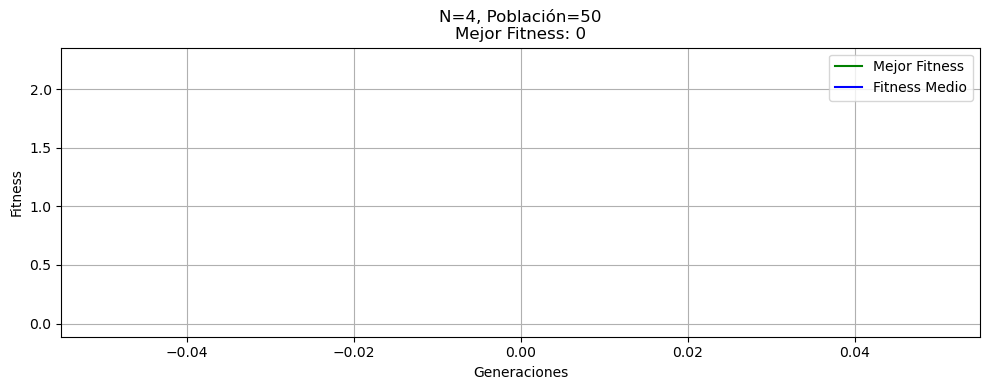

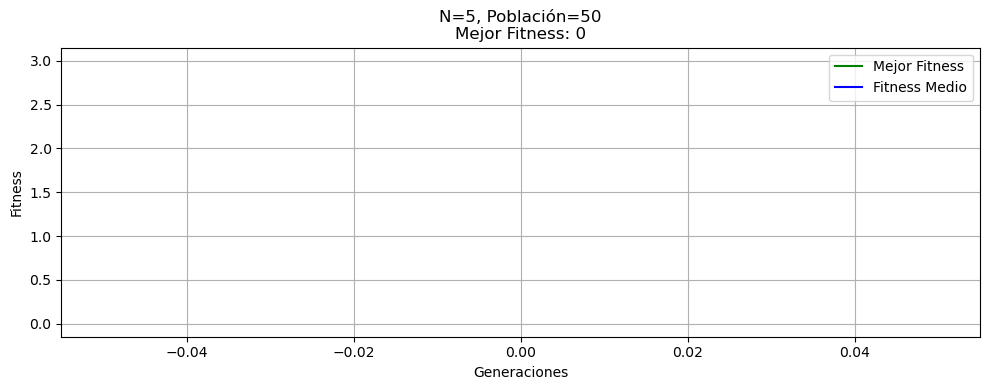

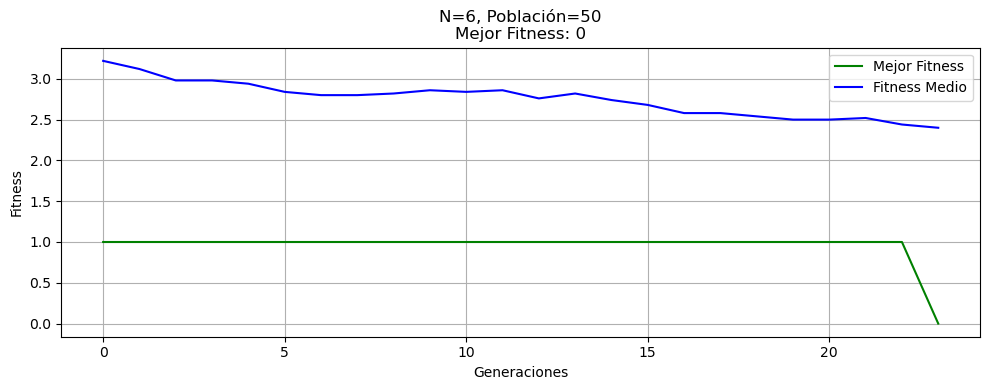

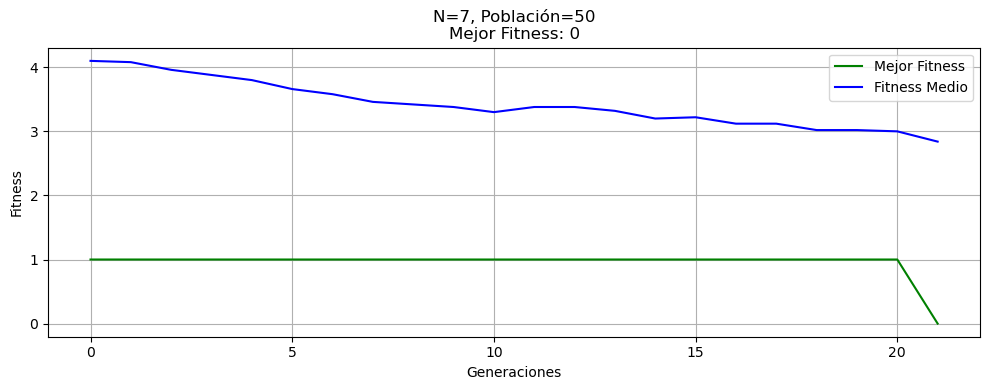

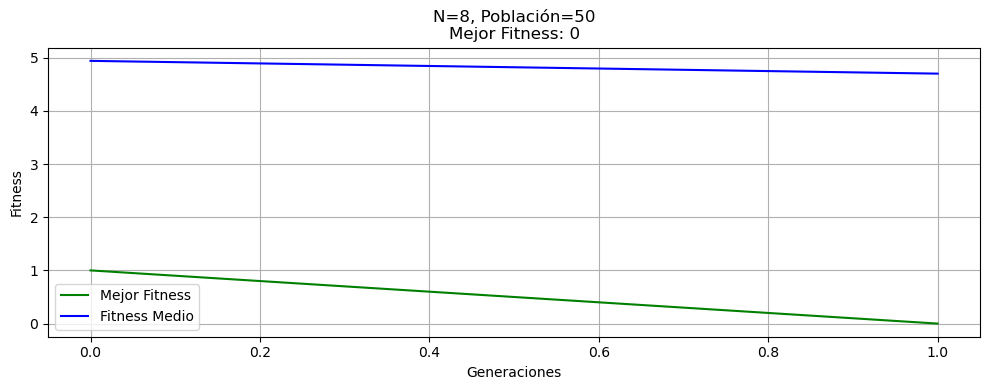

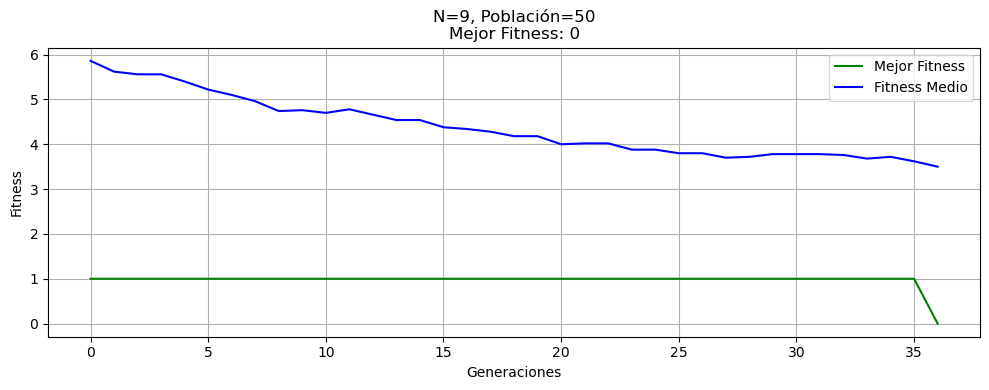

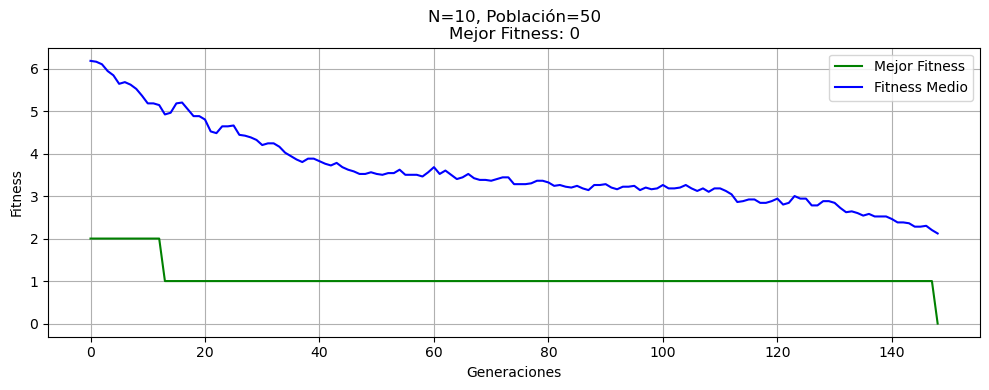

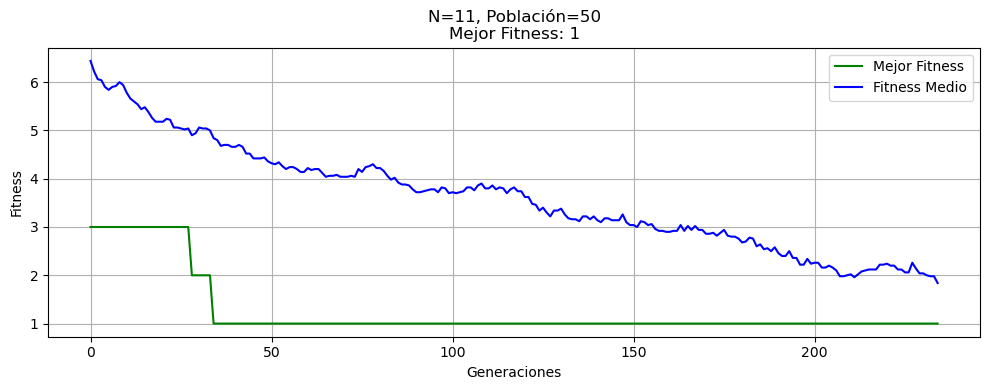

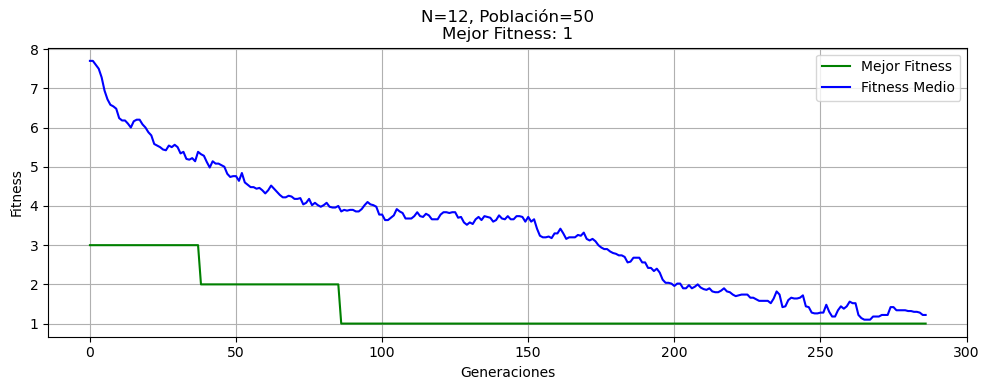

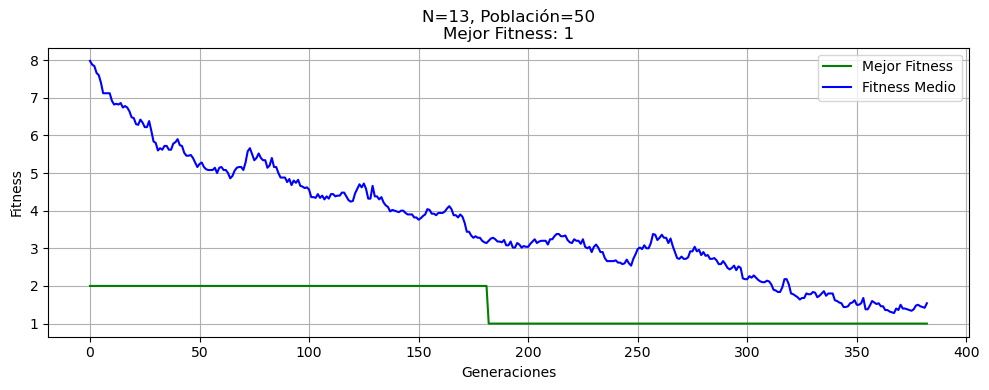

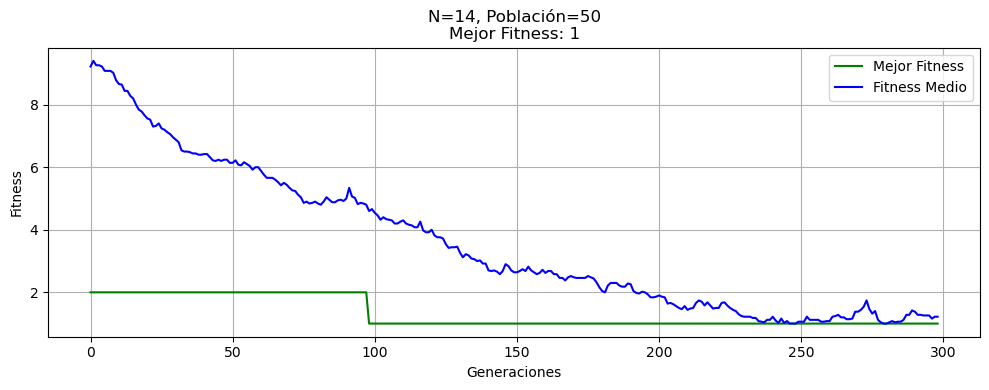

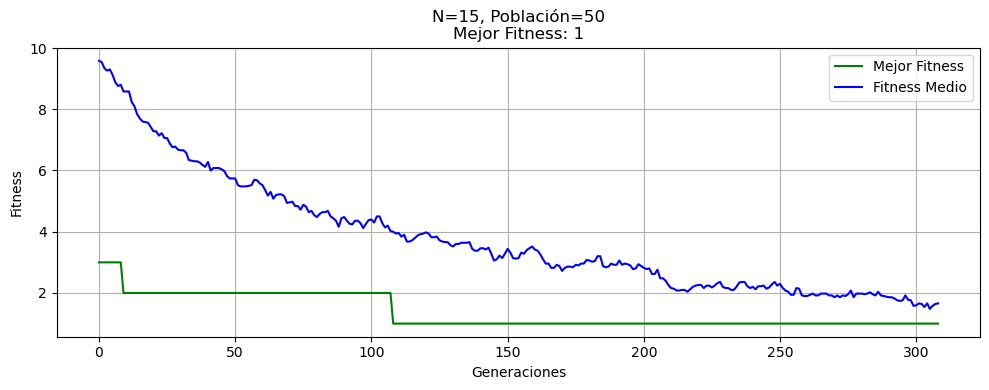

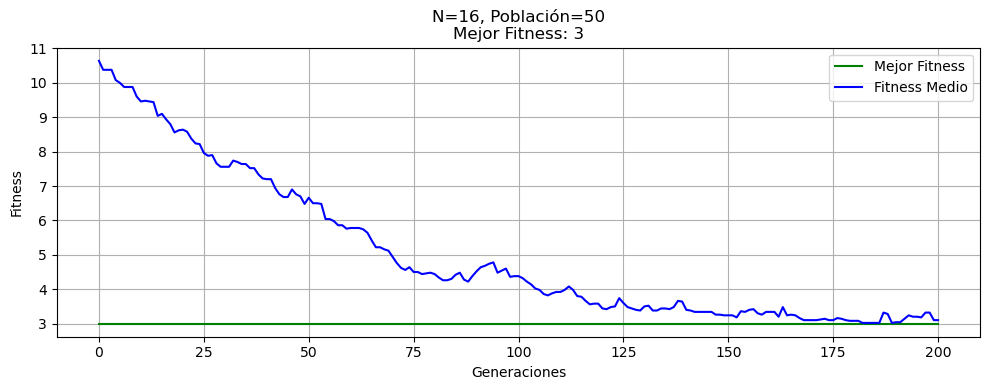

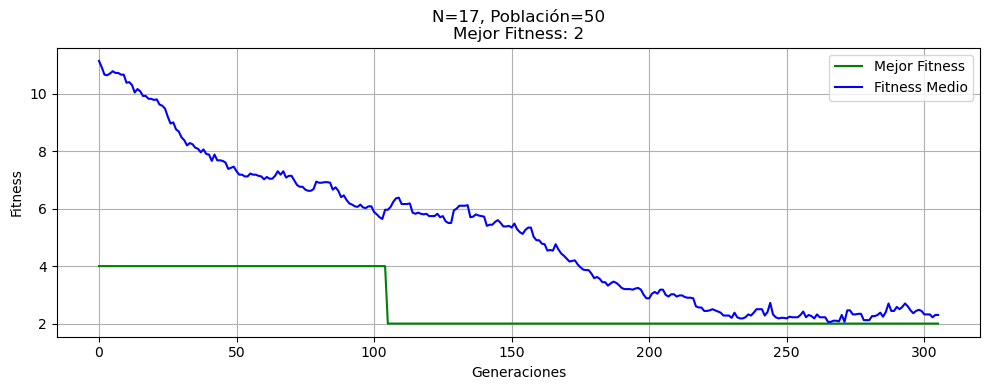

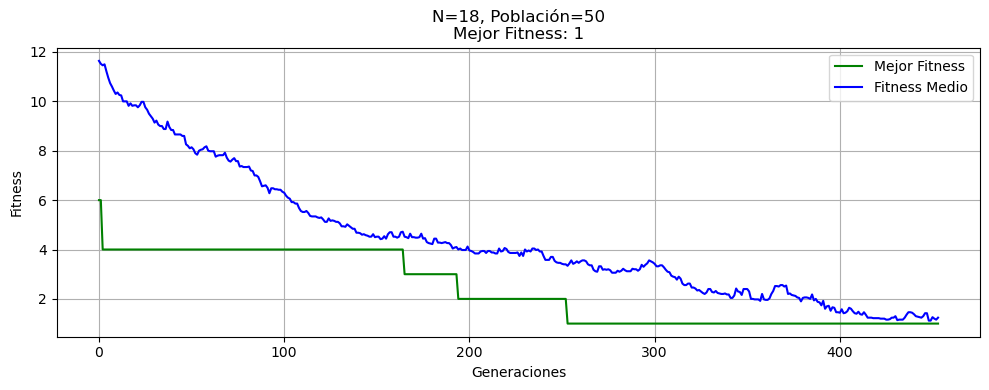

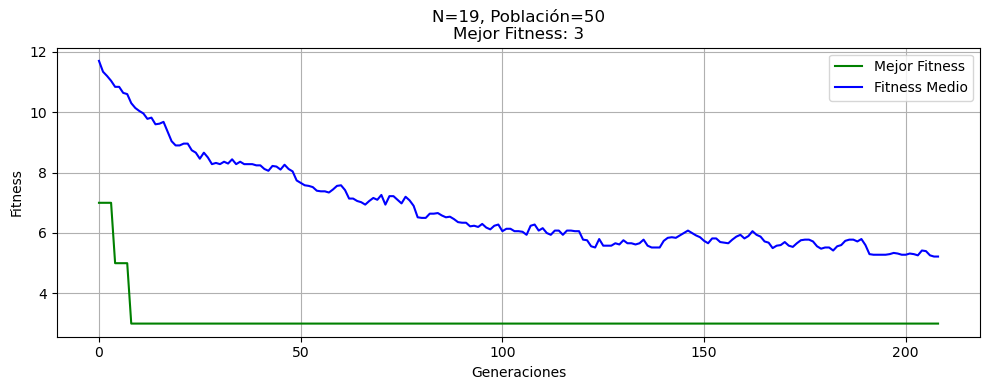

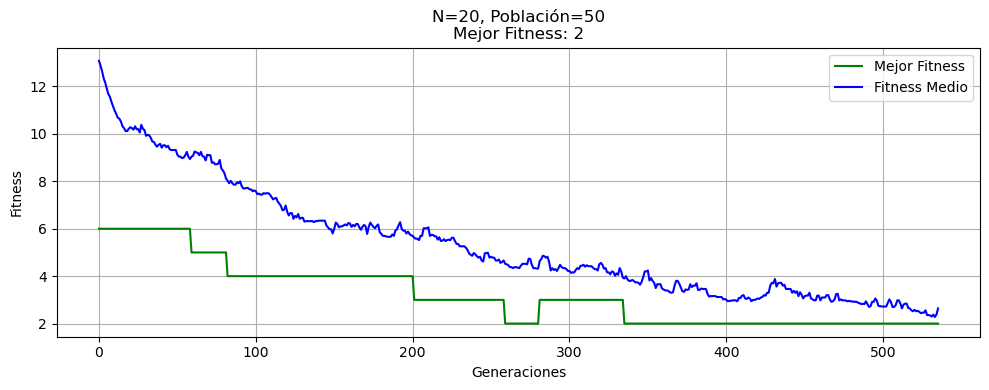

In [ ]:
N_reinas = 20
N_poblacion = 50
num_iteraciones = 500
num_ejecuciones = 3

for n in range(4, N_reinas+1):
    mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion = AG(
        N_poblacion=N_poblacion,
        N_cromosoma=n,
        f_fitness=fitness,
        prob_cruz=0.9,
        prob_mut=0.3,
        max_sin_mejoras=200)

    fig, ax = plt.subplots(figsize=(10, 4))
    titulo = f"N={n}, Población={N_poblacion}\nMejor Fitness: {mejor_fitness}"
    crear_grafico_fitness(mejor_fitness_generacion, fitness_medio_generacion, ax=ax, titulo=titulo)
    plt.tight_layout()
    plt.show()    

Podemos ver que por lo general, cuando N <= 9, el problema se resuelve correctamente. Sin embargo, en cuanto N > 9 el problema no llega en su mayoría de veces a la solución. 

En los casos en los que no se llega a la solución, pueden estar ocurriendo varias cosas:

- La población es dominada por un mínimo local.
- La población no es suficientemente grande variada (poca presión evolutiva), y la convergencia es muy lenta.

## 2. Variación en el tamaño de la población:

Para ver que es lo que pasa, nos centraremos en el problema con N = 20, y probaremos a ejecutar el algoritmo con distitos distintos tamaños de población:

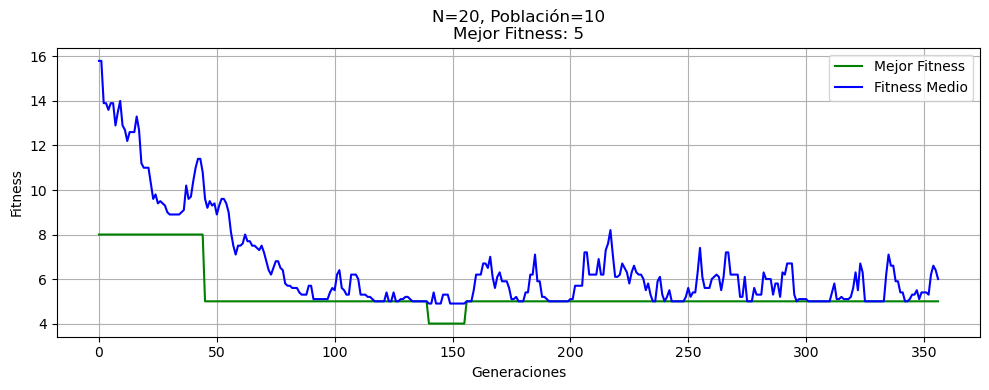

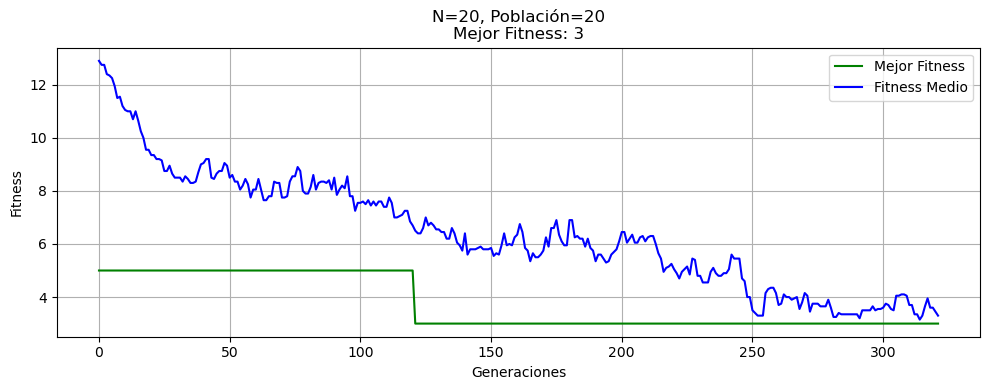

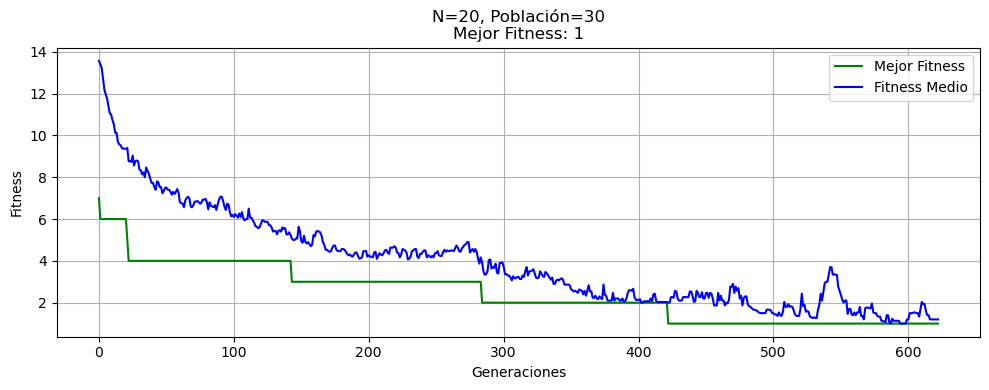

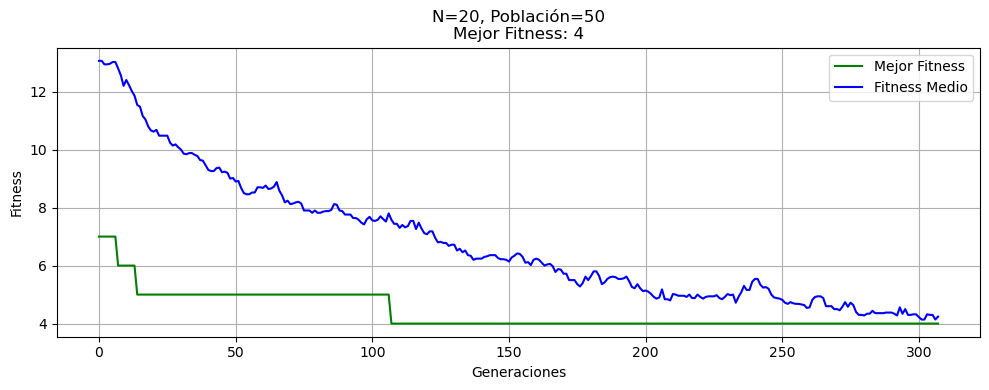

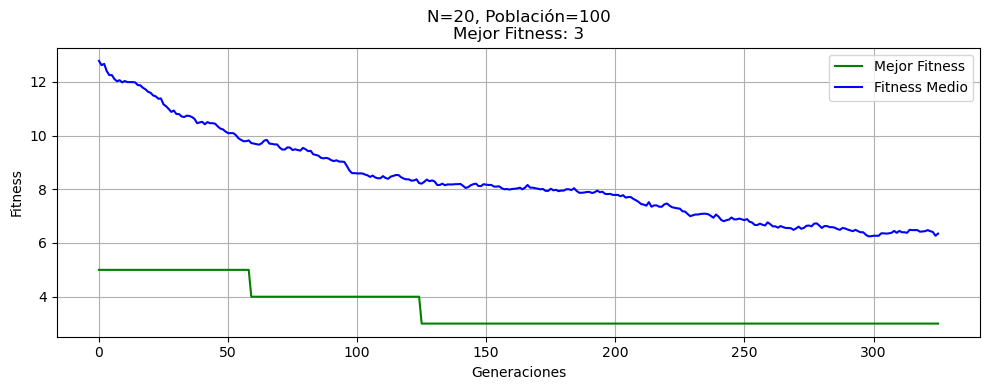

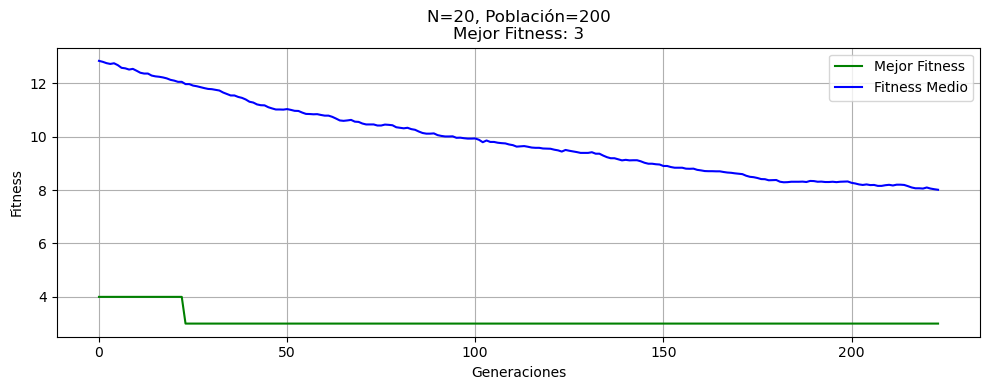

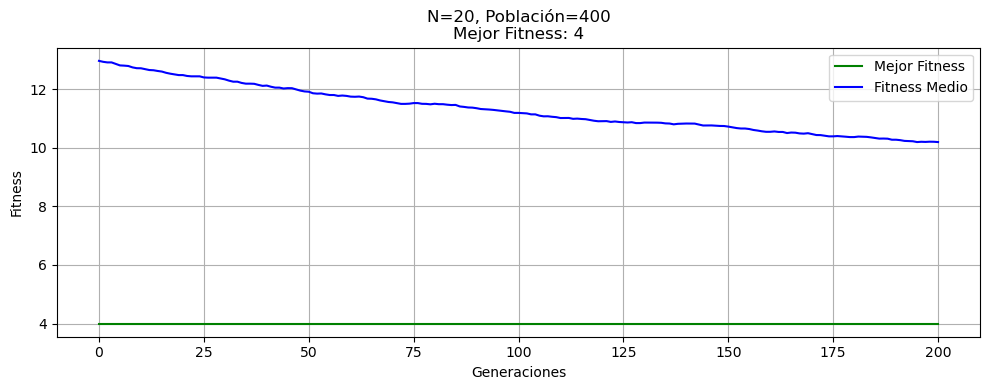

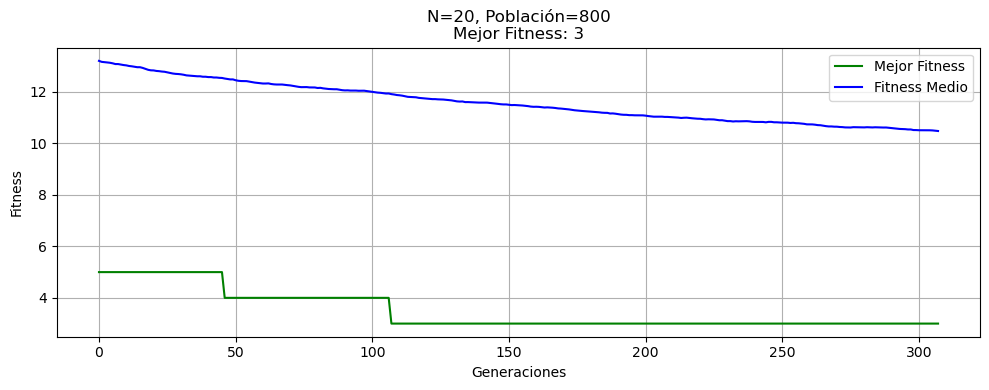

In [68]:
N_reinas = 20
N_poblaciones = [10, 20, 30, 50, 100, 200, 400, 800]

for N_poblacion in N_poblaciones:
    mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion = AG(
        N_poblacion=N_poblacion,
        N_cromosoma=N_reinas,  
        f_fitness=fitness,
        prob_cruz=0.9,
        prob_mut=0.3,
        max_sin_mejoras=200
    )

    fig, ax = plt.subplots(figsize=(10, 4))
    titulo = f"N={N_reinas}, Población={N_poblacion}\nMejor Fitness: {mejor_fitness}"
    crear_grafico_fitness(mejor_fitness_generacion, fitness_medio_generacion, ax=ax, titulo=titulo)
    plt.tight_layout()
    plt.show()   

Se observa que, cuando el tamaño de la población es pequeño, el algoritmo tiende a converger hacia un óptimo local. Esto probablemente se deba a que, en poblaciones reducidas, resulta más fácil que un esquema dominante se imponga sobre el resto de la población.

Por otro lado, al aumentar el tamaño de la población, el algoritmo parece converger de forma más lenta. Esto podría deberse a una menor presión evolutiva. Para verificar esta hipótesis, repetiremos la prueba utilizando un número máximo de generaciones sin mejora igual a 1000.

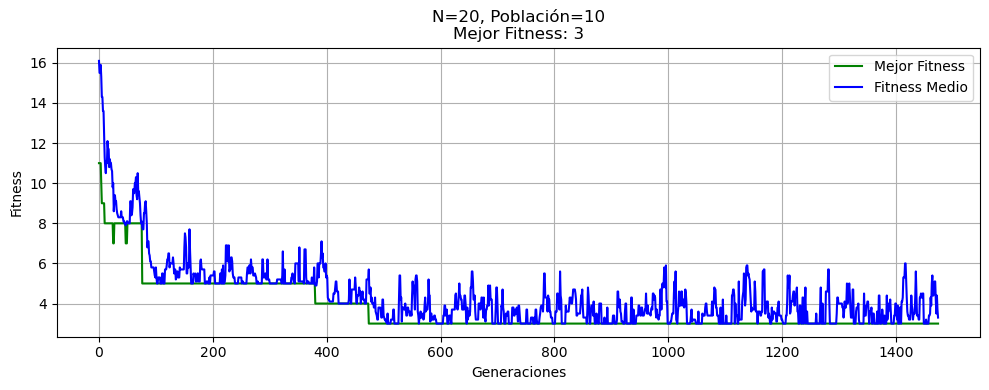

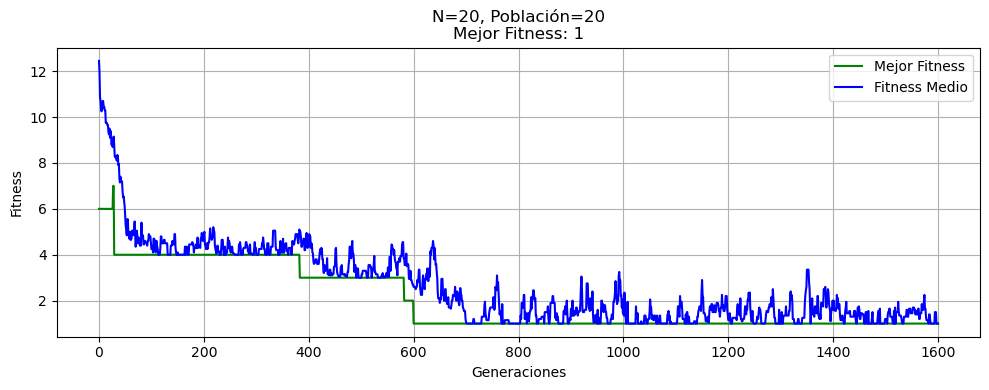

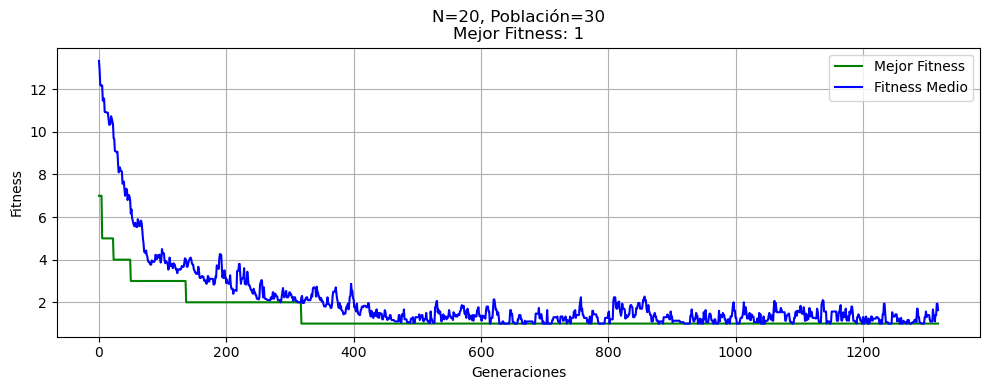

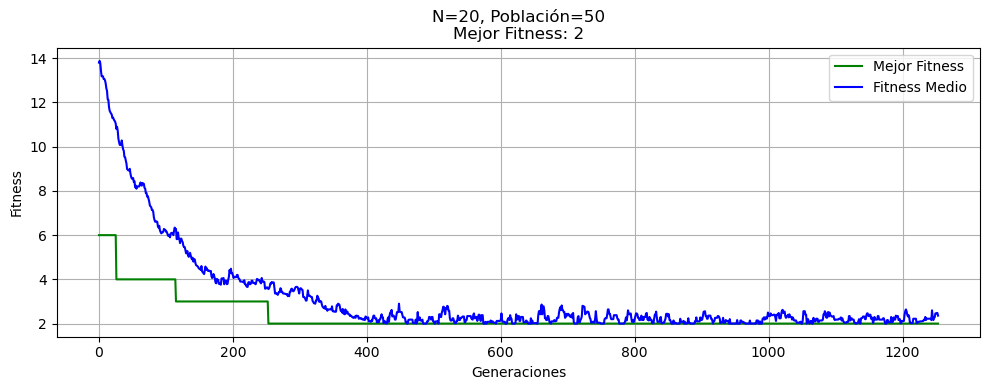

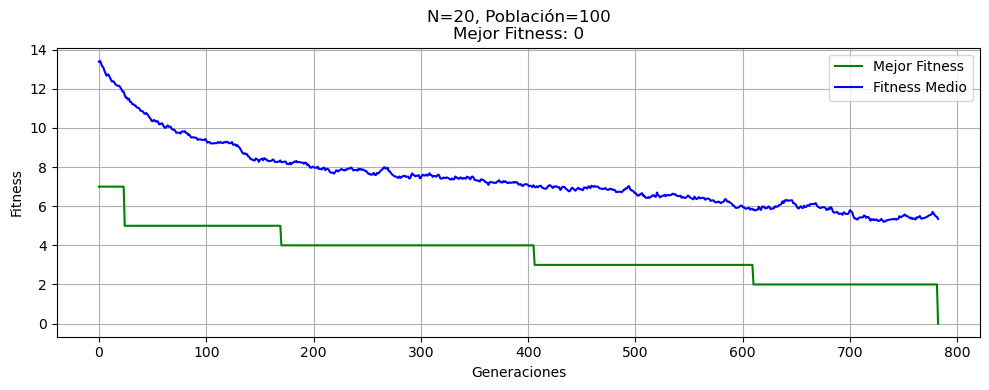

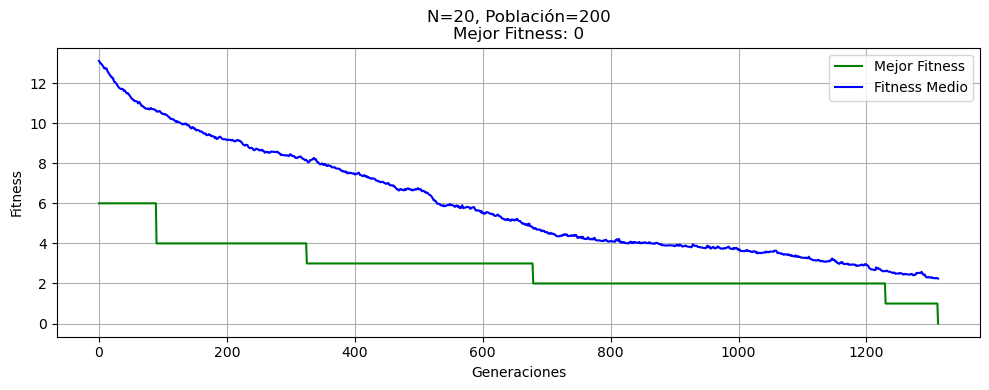

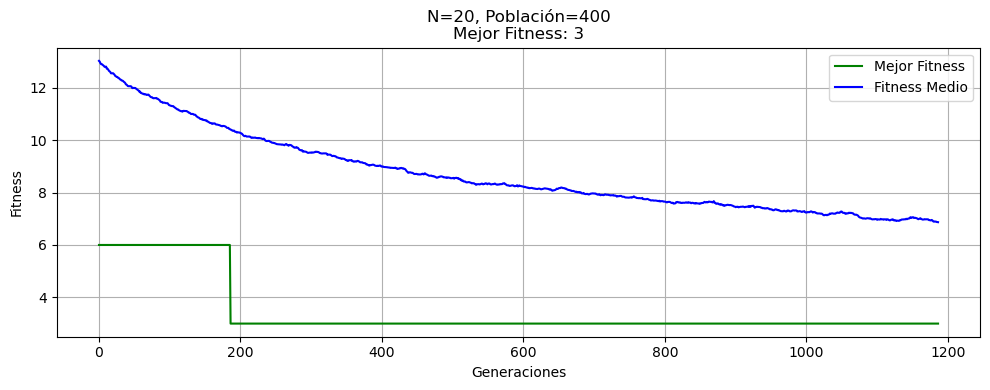

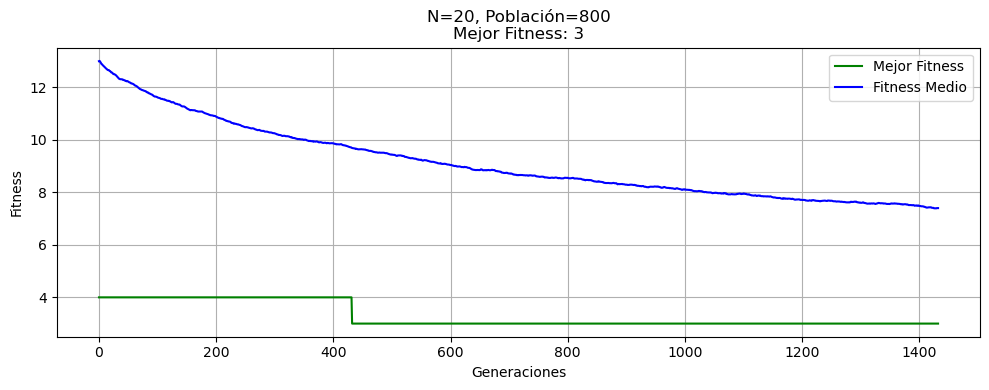

In [69]:
N_reinas = 20
N_poblaciones = [10, 20, 30, 50, 100, 200, 400, 800]

for N_poblacion in N_poblaciones:
    mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion = AG(
        N_poblacion=N_poblacion,
        N_cromosoma=N_reinas,  
        f_fitness=fitness,
        prob_cruz=0.9,
        prob_mut=0.3,
        max_sin_mejoras=1000
    )

    fig, ax = plt.subplots(figsize=(10, 4))
    titulo = f"N={N_reinas}, Población={N_poblacion}\nMejor Fitness: {mejor_fitness}"
    crear_grafico_fitness(mejor_fitness_generacion, fitness_medio_generacion, ax=ax, titulo=titulo)
    plt.tight_layout()
    plt.show()   

Con esta prueba, podemos concluir que, en este caso, incrementar el número de iteraciones no resulta efectivo para resolver el problema. Esto se debe a que la principal dificultad radica en una presión evolutiva insuficiente, lo que provoca que el algoritmo genético tienda a estancarse en óptimos locales o a converger de forma muy lenta hacia una solución adecuada.

## 3. Generación de más descendientes

Con el objetivo de abordar el problema de la baja presión evolutiva, intentaremos generar una mayor cantidad de descendientes. Esto permitirá incrementar la diversidad dentro de la población y aumentará la probabilidad de que alguno de los individuos se acerque a una solución óptima. Para ello, se aplicarán las siguientes estrategias:

- Se seleccionará al **40% de la población** como progenitores.  
- Los progenitores se emparejarán de **dos en dos**, y se aplicará **cruce en el 90%** de los casos.  
- El **30% de los descendientes** generados serán sometidos a **mutación**.


In [71]:
def AG(N_poblacion: int,
       N_cromosoma: int,
       f_fitness: Callable[[List[int]], int],
       prob_progenitor: float = 0.4,
       prob_cruz: float = 0.05,
       prob_mut: float = 0.01,
       max_sin_mejoras: int = 200) -> Tuple['Individuo', int, List[int], List[int]]:
    """
    Ejecuta un algoritmo genético para resolver el problema de las N-reinas.

    :param N_poblacion: Número de individuos en la población.
    :param N_cromosoma: Tamaño del cromosoma (N del problema).
    :param f_fitness: Función de evaluación de fitness.
    :param prob_progenitor: Probabilidad de que un individuo sea progenitor.
    :param prob_cruz: Probabilidad de realizar cruzamiento.
    :param prob_mut: Probabilidad de realizar mutación.
    :param num_iteraciones: Número de generaciones a ejecutar.
    :return: Mejor individuo, su fitness, la evolución del fitness por generación, y 
        la evolución del fitness medio por generación.
    """
    poblacion = Poblacion(N_poblacion=N_poblacion,
                          N_cromosoma=N_cromosoma,
                          f_fitness=f_fitness)

    mejor_fitness_generacion: List[int] = []
    fitness_medio_generacion: List[float] = []

    iteraciones = 0
    while(True):    
        mejor_fitness_generacion.append(np.min(poblacion.fitness_poblacion))
        fitness_medio_generacion.append(poblacion.fitness_medio)

        # Si hemos alcanzado una solución, finalizamos
        if np.min(poblacion.fitness_poblacion) == 0:
            break
        # Si llevamos max_sin_mejoras generaciones sin mejoras, finalizamos
        if iteraciones >= max_sin_mejoras:
            if all(x == mejor_fitness_generacion[iteraciones] for x in mejor_fitness_generacion[iteraciones-max_sin_mejoras : iteraciones+max_sin_mejoras]):
                break

        descendientes: List[Individuo] = []

        progenitores = seleccionar_progenitores_ruleta(poblacion=poblacion, N_progenitores=int(N_poblacion*prob_progenitor))
        for i in range(0, len(progenitores)-1):
            progenitor1, progenitor2 = progenitores[i], progenitores[i+1]

            if np.random.rand() <= prob_cruz:
                # Generamos el primer hijo
                hijo1 = cruzar_progenitores_pmx(progenitor1=progenitor1, 
                                        progenitor2=progenitor2)

                if np.random.rand() <= prob_mut:
                    hijo1 = mutar_individuo_sacudida(hijo1)
                descendientes.append(hijo1)

                # Generamos el segundo hijo
                hijo2 = cruzar_progenitores_pmx(progenitor1=progenitor2, 
                                        progenitor2=progenitor1)

                if np.random.rand() <= prob_mut:
                    hijo2 = mutar_individuo_sacudida(hijo2)
                descendientes.append(hijo2)

        poblacion = seleccionar_supervivientes_ruleta(poblacion=poblacion, descendientes=descendientes)

        iteraciones += 1

    fitness_poblacion = poblacion.fitness_poblacion
    best_idx = np.argmin(fitness_poblacion)
    mejor_solucion = poblacion.individuos[best_idx]
    mejor_fitness = fitness_poblacion[best_idx]

    return mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion

Para probar el nuevo algoritmo, lo ejecutaremos varias veces con distintos tamaños de población. Cada una de las configuraciones la ejecutaremos varias veces para medir la tasa de exito. 

Definimos una función para medir el rendimiento:

Ejecutamos la prueba:

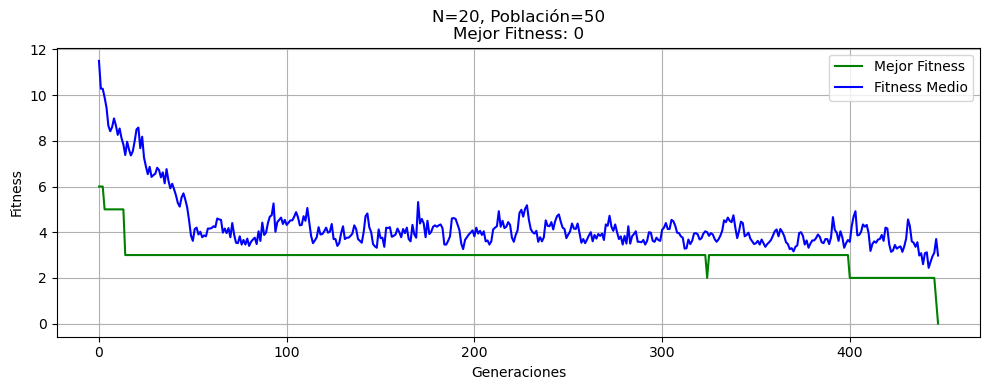

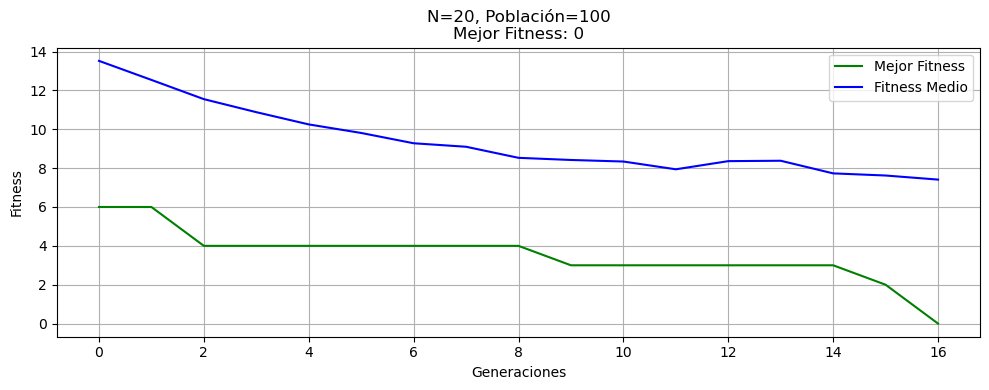

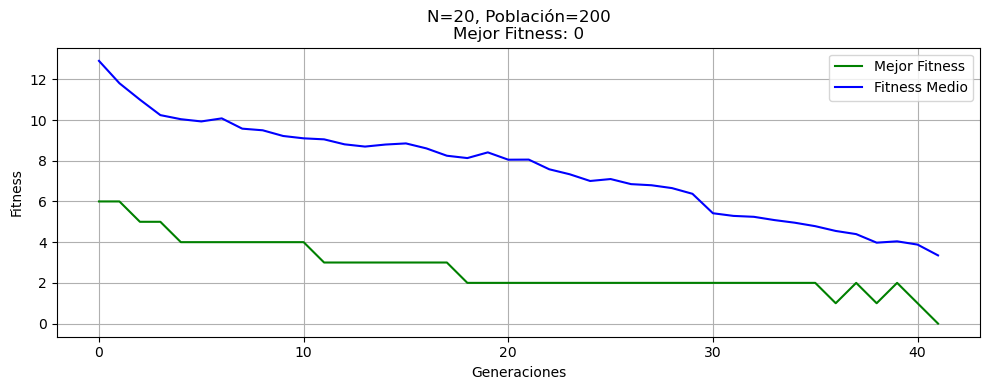

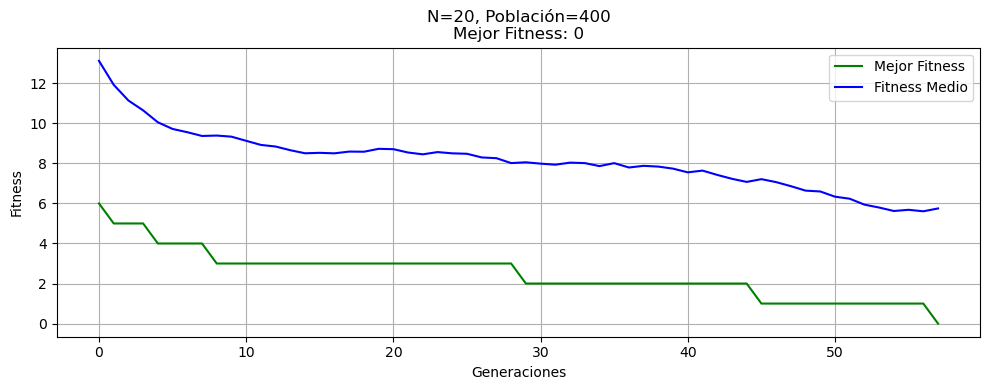

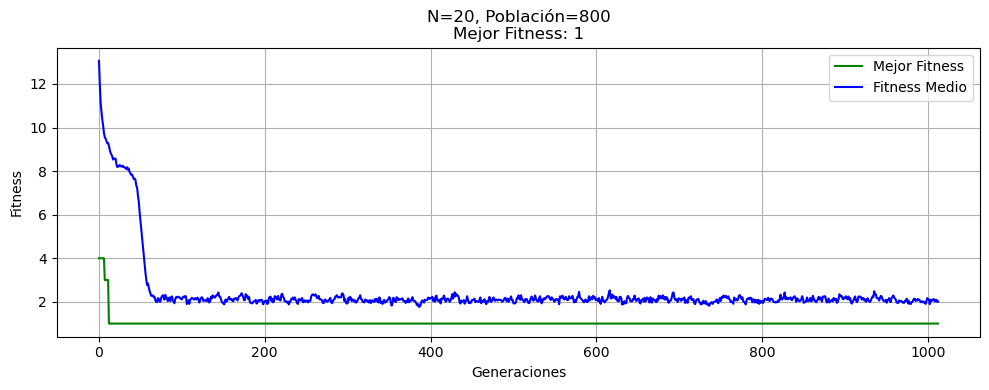

In [72]:
N_reinas = 20
N_poblaciones = [50, 100, 200, 400, 800]

for N_poblacion in N_poblaciones:
    mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion = AG(
        N_poblacion=N_poblacion,
        N_cromosoma=N_reinas,  
        f_fitness=fitness,
        prob_cruz=0.9,
        prob_mut=0.3,
        max_sin_mejoras=1000
    )

    fig, ax = plt.subplots(figsize=(10, 4))
    titulo = f"N={N_reinas}, Población={N_poblacion}\nMejor Fitness: {mejor_fitness}"
    crear_grafico_fitness(mejor_fitness_generacion, fitness_medio_generacion, ax=ax, titulo=titulo)
    plt.tight_layout()
    plt.show()  

Al aumentar la cantidad de descendientes generados en cada generación, se incrementa la presión evolutiva, lo que permite al algoritmo genético encontrar soluciones al problema de las 20 reinas. Este ajuste favorece una exploración más eficiente del espacio de búsqueda, mientras que una alta tasa de cruzamiento, combinada con una mutación equilibrada, contribuye a mantener una diversidad genética adecuada y a prevenir la convergencia prematura.

Los resultados muestran que en la mayoría de casos, el algoritmo consigue hallar una solución. No obstante, en los casos en los que no se ha llegado a una solución (población de 800 individuos) e incluso en los que si se ha llegado (población de 50 individuos), se observan aún muchas generaciones sin mejora del mejor individuo, lo que evidencia que la presión evolutiva podría seguir siendo insuficiente. Hay que tener en cuenta que la aleatoriedad juega un papel clave en estos algoritmos, y que lo que en una ejecución ha quedado estancado, en otra podría encontrar la solución rápidamente. 

Además, el aumento en la cantidad de descendientes por generación conlleva un mayor coste computacional por iteración. Por ello, no resulta conveniente utilizar poblaciones excesivamente grandes ni prolongar innecesariamente el número de generaciones, ya que esto compromete la eficiencia del algoritmo.

## 4. Escalamiento sigma de Goldberg:

Para tratar de solucionar el problema de la convergencia prematura, se aplicará el **escalamiento sigma de Goldberg** en el proceso de selección de progenitores y supervivientes. Esta técnica ajusta los valores de aptitud (fitness) para mantener una presión selectiva adecuada a lo largo de las generaciones, evitando que unos pocos individuos dominen la población demasiado pronto.

La fórmula del escalamiento sigma es la siguiente:

$$
f'_i = \max \left( f_i - (\bar{f} - c \cdot \sigma_f), \ 0 \right)
$$

donde:

- $f'_i$ es el fitness escalado del individuo $i$  
- $f_i$ es el fitness original del individuo $i$  
- $\bar{f}$ es el fitness promedio de la población  
- $\sigma_f$ es la desviación estándar del fitness en la población  
- $c$ es la constante de control (cogeremos $c = 2$)

Este método permite conservar la diversidad genética por más tiempo, al reducir la presión selectiva cuando las diferencias entre los individuos son pequeñas.

Primero crearemos una función que calcule el escalamiento sigma los individuos de una población:

In [22]:
def escalamiento_sigma(poblacion):
    fitness_poblacion = poblacion.fitness_poblacion

    # Calculamos los estadísticos necesarios
    mean = np.mean(fitness_poblacion)
    std = np.std(fitness_poblacion)

    # Calculamos el fitness escalado
    fitness_escalado = [np.max([f_i - (mean - 2*std), 0]) for f_i in fitness_poblacion]

    return fitness_escalado

Modificamos la función de selección de progenitores:

In [23]:
def seleccionar_progenitores_ruleta(poblacion: 'Poblacion', N_progenitores: int) -> List['Individuo']:
    """
    Selecciona un número de progenitores de la población utilizando el método de la ruleta,
    donde los individuos con mejor fitness (fitness más bajo) tienen mayor probabilidad de ser seleccionados.
    La selección es sin reemplazo, lo que evita que un individuo sea seleccionado más de una vez.

    :param poblacion: La población de individuos de la cual se seleccionan los progenitores.
    :param N_progenitores: El número de progenitores que se desean seleccionar.
    :return: Una lista de progenitores seleccionados.
    """
    # Calculamos las probabilidades basadas en el fitness invertido (fitness bajo = mejor)
    fitness_escalado = escalamiento_sigma(poblacion)
    fitness_invertido = 1 / (1 + np.array(fitness_escalado))

    # Seleccionamos los progenitores sin reemplazo
    progenitores_indices = np.random.choice(len(poblacion.individuos), size=N_progenitores, replace=False, p=fitness_invertido / np.sum(fitness_invertido))
    
    progenitores = [poblacion.individuos[i] for i in progenitores_indices]

    return progenitores

Modificamos la función de selección de supervivientes:

In [24]:
def seleccionar_supervivientes_ruleta(poblacion: 'Poblacion', descendientes: List['Individuo']) -> 'Poblacion':
    """
    Selecciona a los mejores individuos de la población actual y los descendientes utilizando el método de la ruleta.
    Los individuos con mejor fitness (fitness más bajo) tienen mayor probabilidad de ser seleccionados.

    :param poblacion: Objeto de la clase Poblacion que representa la población actual.
    :param descendientes: Lista de individuos generados en la última generación (descendientes).
    :return: Nueva población formada por los mejores individuos seleccionados.
    """
    # Agregamos los descendientes a la población actual
    individuos = poblacion.individuos + descendientes
    f_fitness = individuos[0].f_fitness
    # Creamos la población sin eliminaciones
    poblacion_nueva = Poblacion(
        N_poblacion=poblacion.N_poblacion,
        N_cromosoma=poblacion.N_cromosoma,
        f_fitness=f_fitness,
        individuos=individuos
    )
    
    # Obtenemos los fitness de todos los individuos
    fitness_escalado = escalamiento_sigma(poblacion_nueva)
    
    # Calculamos las probabilidades basadas en el fitness invertido (fitness bajo = mejor)
    fitness_invertido = 1 / (1 + np.array(fitness_escalado))  # Sumamos 1 para evitar división por 0
    
    # Normalizamos las probabilidades
    probabilidades = fitness_invertido / np.sum(fitness_invertido)
    
    # Seleccionamos los supervivientes (mismo tamaño que la población original)
    supervivientes_indices = np.random.choice(len(individuos), size=poblacion.N_poblacion, replace=False, p=probabilidades)
    
    supervivientes = [individuos[i] for i in supervivientes_indices]
    
    # Creamos una nueva población con los mejores individuos seleccionados
    poblacion_superviviente = Poblacion(
        N_poblacion=poblacion.N_poblacion,
        N_cromosoma=poblacion.N_cromosoma,
        f_fitness=f_fitness,
        individuos=supervivientes
    )
    
    return poblacion_superviviente

Ejecutamos la prueba de antes pero con el escalamiento:

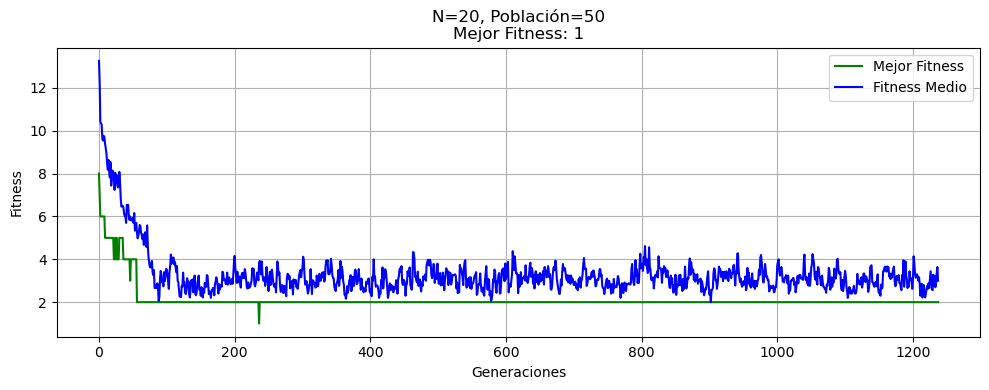

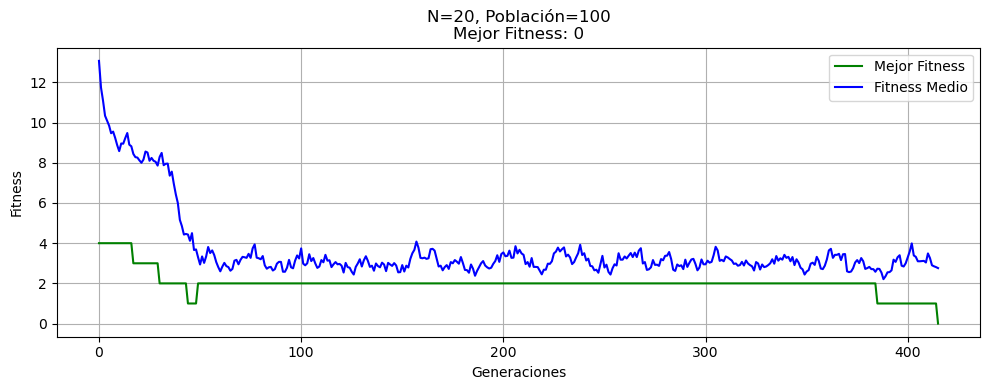

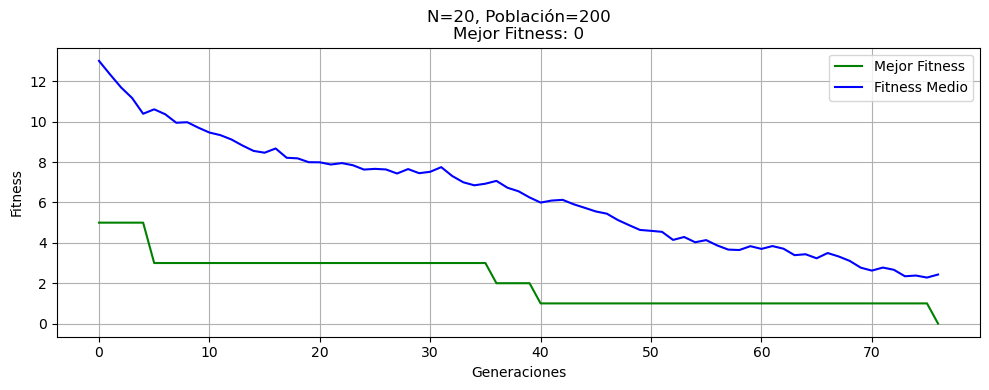

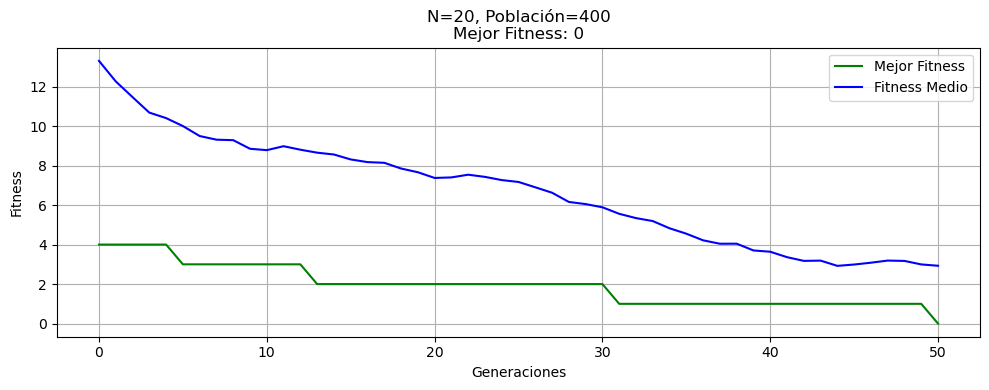

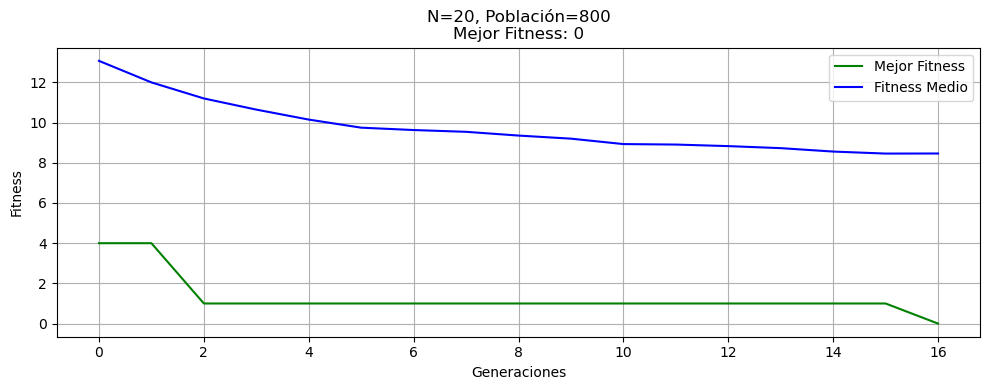

In [25]:
N_reinas = 20
N_poblaciones = [50, 100, 200, 400, 800]

for N_poblacion in N_poblaciones:
    mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion = AG(
        N_poblacion=N_poblacion,
        N_cromosoma=N_reinas,  
        f_fitness=fitness,
        prob_cruz=0.9,
        prob_mut=0.3,
        max_sin_mejoras=1000
    )

    fig, ax = plt.subplots(figsize=(10, 4))
    crear_grafico_fitness(mejor_fitness_generacion, fitness_medio_generacion, N_reinas=N_reinas, tam_poblacion=N_poblacion, ax=ax)
    plt.tight_layout()
    plt.show()  

En este caso, podemos observar un comportamiento característico de la convergencia prematura. Cuando el tamaño de la población es menor a 200, el algoritmo no converge fácilmente a un óptimo global, lo que indica que queda atrapado temporalmente en óptimos locales. A pesar de ello, si analizamos la distancia entre las curvas de fitness medio y del mejor fitness, se puede apreciar una mayor diversidad en la población en comparación con la prueba anterior.

Esto sugiere que el uso del escalamiento sigma está siendo beneficioso, ya que contribuye a mantener la diversidad genética durante más generaciones. En particular, cuando el tamaño poblacional es igual o superior a 200, el efecto del escalamiento es más notable: el algoritmo no solo evita la convergencia prematura, sino que también logra alcanzar soluciones óptimas en menos generaciones.

## 5. Efecto de los distintos tipos de mutación:

La mutación desempeña un papel fundamental en los algoritmos genéticos. Cuando el algoritmo queda atrapado en un óptimo local, la mutación se convierte en un mecanismo esencial para introducir variación en los descendientes, permitiendo así escapar de esos mínimos y acercarse progresivamente a una solución óptima.

Para evaluar su impacto en el rendimiento del algoritmo, probaremos diferentes enfoques de mutación en los cromosomas. El objetivo es identificar qué método favorece una mejora más rápida del mejor fitness por generación y, en consecuencia, acelera la convergencia del algoritmo. Estos son las técnicas de mutación que utilizaremos:

- Mutación por sacudida (actual)
- Mutación por intercambio
- Mutación por inserción
- Mutación por inversión

Para poder realizar las pruebas, primero modificaremos el algoritmo genético, de tal manera que se pueda elegir la función de mutación a utilizar:

In [35]:
def AG(N_poblacion: int,
       N_cromosoma: int,
       f_fitness: Callable[[List[int]], int],
       f_mutacion: Callable[['Individuo'], 'Individuo'],
       prob_progenitor: float = 0.4,
       prob_cruz: float = 0.05,
       prob_mut: float = 0.01,
       max_sin_mejoras: int = 200) -> Tuple['Individuo', int, List[int], List[int]]:
    """
    Ejecuta un algoritmo genético para resolver el problema de las N-reinas.

    :param N_poblacion: Número de individuos en la población.
    :param N_cromosoma: Tamaño del cromosoma (N del problema).
    :param f_fitness: Función de evaluación de fitness.
    :param f_mutacion: Función de mutación de los cromosomas.
    :param prob_progenitor: Probabilidad de que un individuo sea progenitor.
    :param prob_cruz: Probabilidad de realizar cruzamiento.
    :param prob_mut: Probabilidad de realizar mutación.
    :param max_sin_mejoras: Número de generaciones a ejecutar.
    :return: Mejor individuo, su fitness, la evolución del fitness por generación, y 
        la evolución del fitness medio por generación.
    """
    poblacion = Poblacion(N_poblacion=N_poblacion,
                          N_cromosoma=N_cromosoma,
                          f_fitness=f_fitness)

    mejor_fitness_generacion: List[int] = []
    fitness_medio_generacion: List[float] = []

    iteraciones = 0
    while(True):   
        mejor_fitness_generacion.append(np.min(poblacion.fitness_poblacion))
        fitness_medio_generacion.append(poblacion.fitness_medio)
        
        if np.min(poblacion.fitness_poblacion) == 0:
            break

        # Si llevamos max_sin_mejoras generaciones sin mejoras, finalizamos
        if iteraciones >= max_sin_mejoras:
            if all(x == mejor_fitness_generacion[iteraciones] for x in mejor_fitness_generacion[iteraciones-max_sin_mejoras : iteraciones+max_sin_mejoras]):
                break

        descendientes: List[Individuo] = []

        progenitores = seleccionar_progenitores_ruleta(poblacion=poblacion, N_progenitores=int(N_poblacion*prob_progenitor))
        for i in range(0, len(progenitores)-1):
            progenitor1, progenitor2 = progenitores[i], progenitores[i+1]

            if np.random.rand() <= prob_cruz:
                # Generamos el primer hijo
                hijo1 = cruzar_progenitores_pmx(progenitor1=progenitor1, 
                                        progenitor2=progenitor2)

                if np.random.rand() <= prob_mut:
                    hijo1 = f_mutacion(hijo1)
                descendientes.append(hijo1)

                # Generamos el segundo hijo
                hijo2 = cruzar_progenitores_pmx(progenitor1=progenitor2, 
                                        progenitor2=progenitor1)

                if np.random.rand() <= prob_mut:
                    hijo2 = f_mutacion(hijo2)
                descendientes.append(hijo2)

        poblacion = seleccionar_supervivientes_ruleta(poblacion=poblacion, descendientes=descendientes)

        iteraciones += 1

    fitness_poblacion = poblacion.fitness_poblacion
    best_idx = np.argmin(fitness_poblacion)
    mejor_solucion = poblacion.individuos[best_idx]
    mejor_fitness = fitness_poblacion[best_idx]

    return mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion

### 5.1. Mutación por intercambio:

Creamos la función encargada de mutar por intercambio:

In [29]:
def mutar_individuo_intercambio(individuo: 'Individuo') -> 'Individuo':
    """
    Aplica la mutación por intercambio a un cromosoma.
    Se seleccionan 2 genes aleatorios y se intercambian.

    :param cromosoma: Cromosoma original (permutación de enteros).
    :return: Cromosoma mutado.
    """
    cromosoma = individuo.cromosoma
    mutado = cromosoma.copy()
    N_cromosoma = len(cromosoma)

    # Seleccionar dos índices aleatorios distintos
    i, j = sorted(random.sample(range(N_cromosoma), 2))

    # Intercambiamos las posiciones
    mutado[i], mutado[j] = mutado[j], mutado[i] 

    return Individuo(N_cromosoma=N_cromosoma, 
                     f_fitness=individuo.f_fitness, 
                     cromosoma=mutado)

Creamos la función encargada de mutar por inserción:

In [30]:
def mutar_individuo_insercion(individuo: 'Individuo') -> 'Individuo':
    """
    Aplica la mutación por inserción a un cromosoma.
    Se seleccionan dos posiciones aleatorias y el gen en la segunda posición se inserta en la primera.

    :param cromosoma: Cromosoma original (permutación de enteros).
    :return: Cromosoma mutado.
    """
    cromosoma = individuo.cromosoma
    mutado = cromosoma.copy()
    N_cromosoma = len(cromosoma)

    # Seleccionar dos índices aleatorios distintos
    i, j = sorted(random.sample(range(N_cromosoma), 2))

    # Realizamos la inserción
    elemento = mutado.pop(j) 
    mutado.insert(i, elemento) 

    return Individuo(N_cromosoma=N_cromosoma, 
                     f_fitness=individuo.f_fitness, 
                     cromosoma=mutado)

Creamos la función encargada de mutar por inversión:

In [31]:
def mutar_individuo_inversion(individuo: 'Individuo') -> 'Individuo':
    """
    Aplica la mutación por inversión a un cromosoma.
    Se seleccionan dos posiciones aleatorias y se invierten los genes entre esas dos posiciones.

    :param cromosoma: Cromosoma original (permutación de enteros).
    :return: Cromosoma mutado.
    """
    cromosoma = individuo.cromosoma
    mutado = cromosoma.copy()
    N_cromosoma = len(cromosoma)

    # Seleccionar dos índices aleatorios distintos
    i, j = sorted(random.sample(range(N_cromosoma), 2))

    # Realizamos la inversión
    mutado[i:j+1] = reversed(mutado[i:j+1])

    return Individuo(N_cromosoma=N_cromosoma, 
                     f_fitness=individuo.f_fitness, 
                     cromosoma=mutado)

Realizando pruebas para poblacion=50...
Realizando pruebas para poblacion=100...
Realizando pruebas para poblacion=200...
Realizando pruebas para poblacion=400...
Realizando pruebas para poblacion=800...


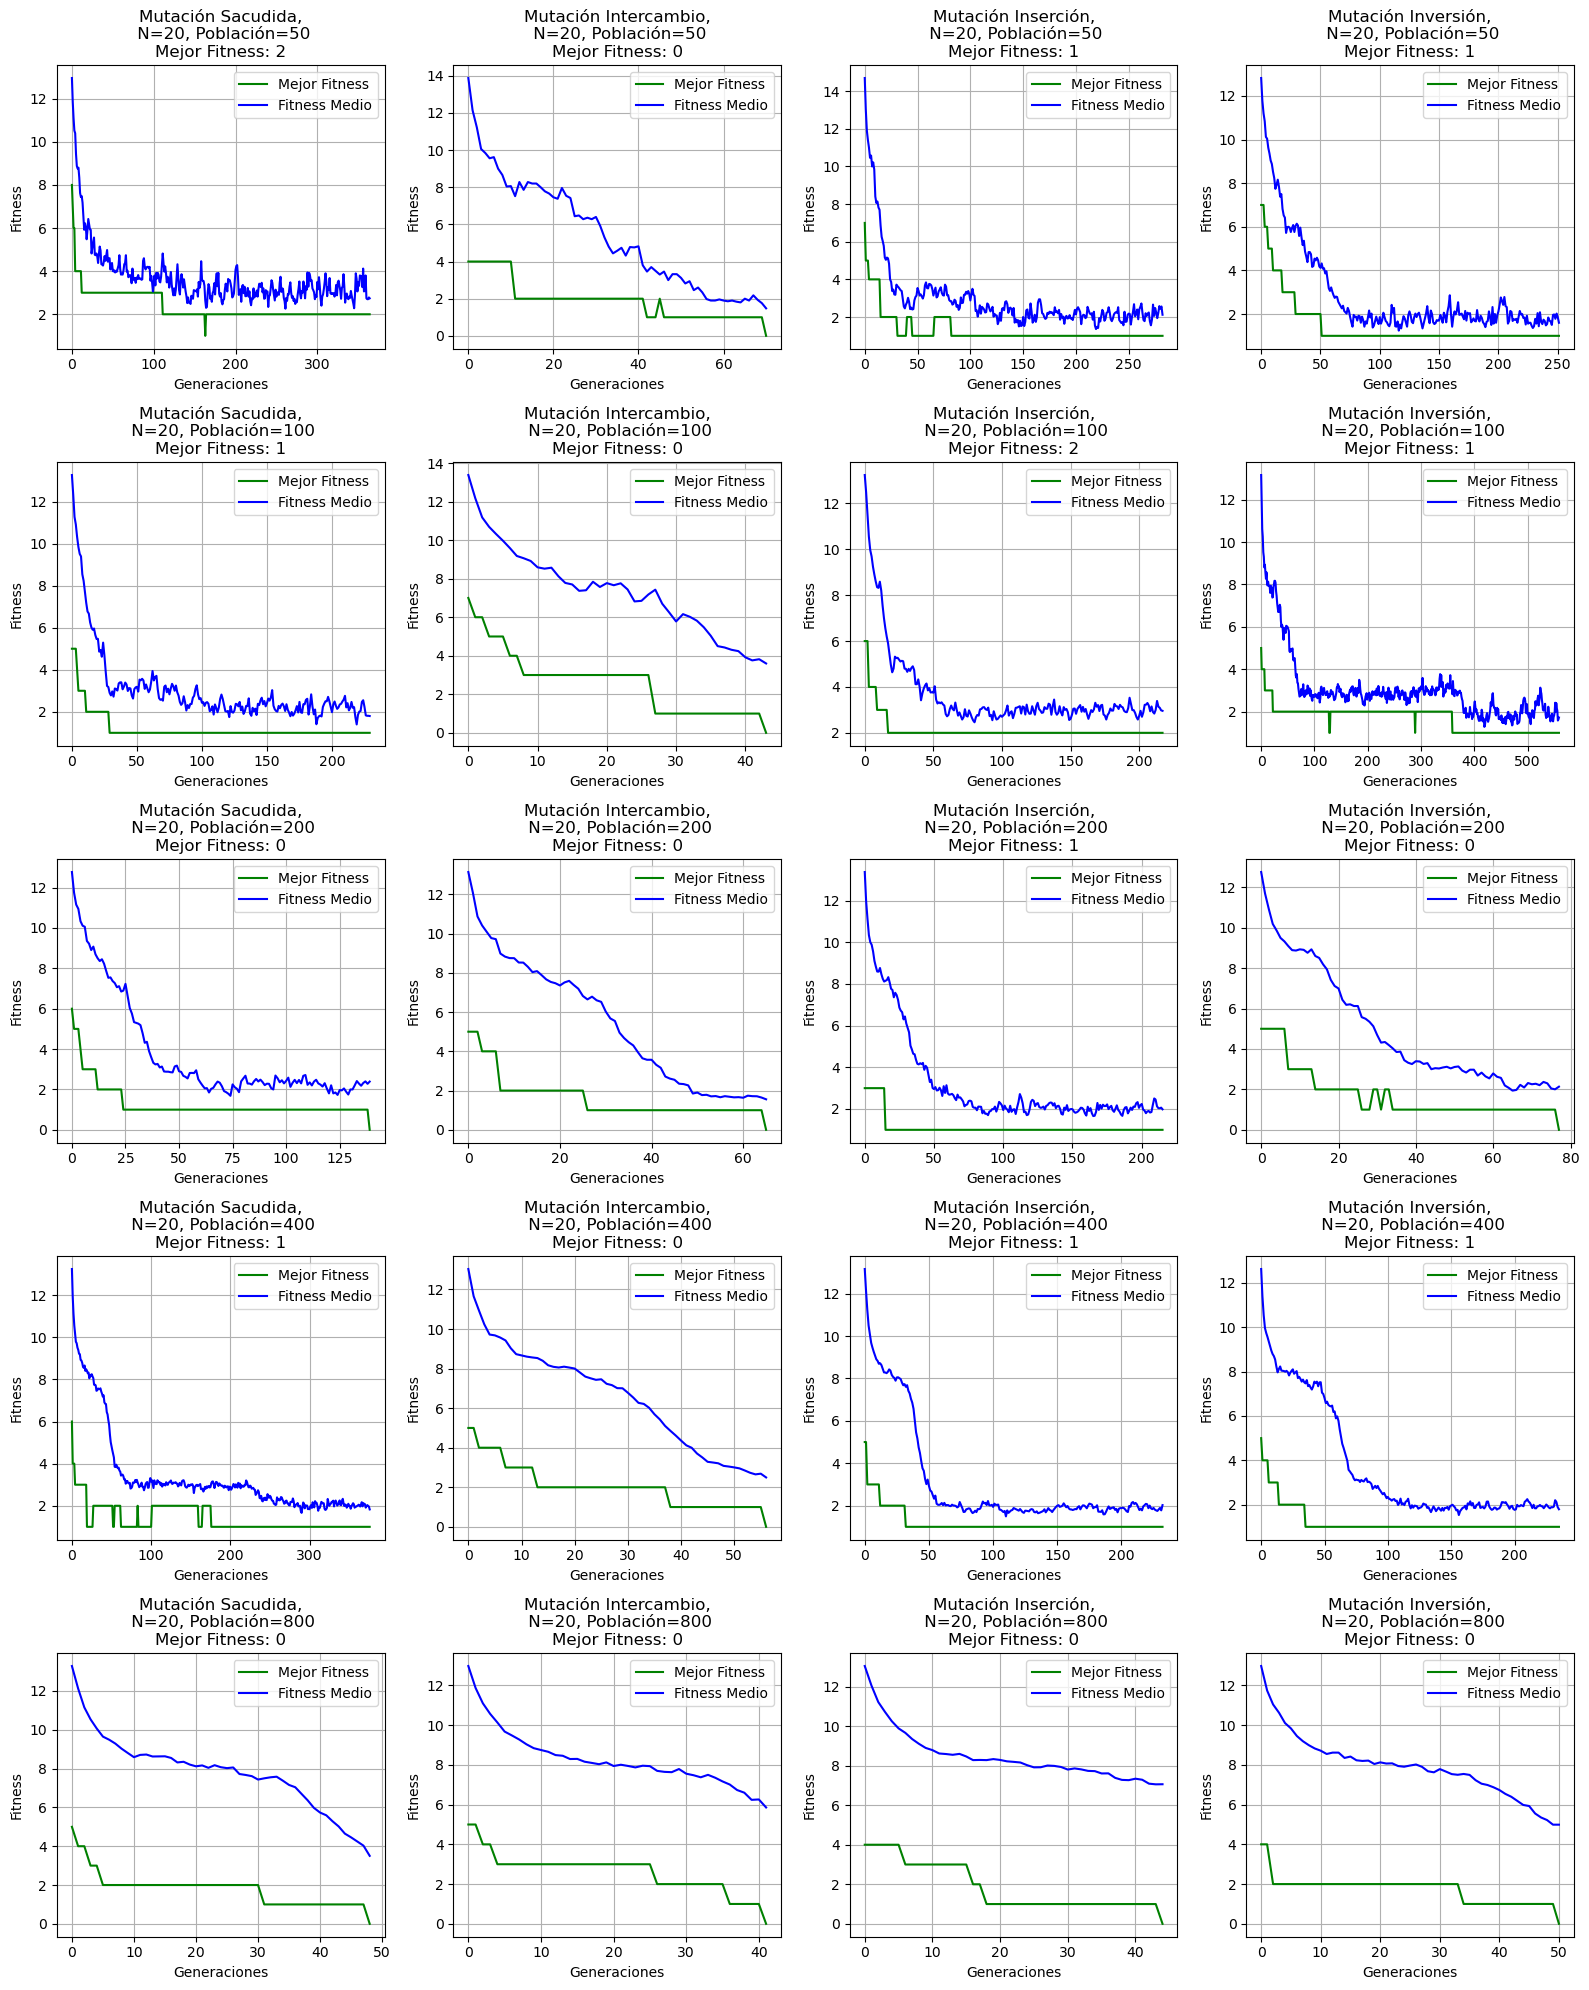

In [59]:
N_reinas = 20
N_poblaciones = [50, 100, 200, 400, 800]

fig, ax = plt.subplots(figsize=(16, 20), ncols=4, nrows=len(N_poblaciones))
column_titles = [
    "Mutación Sacudida",
    "Mutación Intercambio",
    "Mutación Inserción",
    "Mutación Inversión"
]

for i, N_poblacion in enumerate(N_poblaciones):

    print(f"Realizando pruebas para poblacion={N_poblacion}...")
    mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion = AG(
        N_poblacion=N_poblacion,
        N_cromosoma=N,  
        f_fitness=fitness,
        f_mutacion=mutar_individuo_sacudida,
        prob_cruz=0.9,
        prob_mut=0.3,
        max_sin_mejoras=200
    )
    titulo = f"{column_titles[0]},\n N={N_reinas}, Población={N_poblacion}\nMejor Fitness: {mejor_fitness}"
    crear_grafico_fitness(mejor_fitness_generacion, fitness_medio_generacion, ax=ax[i, 0], titulo=titulo)

    mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion = AG(
        N_poblacion=N_poblacion,
        N_cromosoma=N,  
        f_fitness=fitness,
        f_mutacion=mutar_individuo_intercambio,
        prob_cruz=0.9,
        prob_mut=0.3,
        max_sin_mejoras=200
    )

    titulo = f"{column_titles[1]},\n N={N_reinas}, Población={N_poblacion}\nMejor Fitness: {mejor_fitness}"
    crear_grafico_fitness(mejor_fitness_generacion, fitness_medio_generacion, ax=ax[i, 1], titulo=titulo)

    mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion = AG(
        N_poblacion=N_poblacion,
        N_cromosoma=N,  
        f_fitness=fitness,
        f_mutacion=mutar_individuo_insercion,
        prob_cruz=0.9,
        prob_mut=0.3,
        max_sin_mejoras=200
    )

    titulo = f"{column_titles[2]},\n N={N_reinas}, Población={N_poblacion}\nMejor Fitness: {mejor_fitness}"
    crear_grafico_fitness(mejor_fitness_generacion, fitness_medio_generacion, ax=ax[i, 2], titulo=titulo)

    mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion = AG(
        N_poblacion=N_poblacion,
        N_cromosoma=N,  
        f_fitness=fitness,
        f_mutacion=mutar_individuo_inversion,
        prob_cruz=0.9,
        prob_mut=0.3,
        max_sin_mejoras=200
    )

    titulo = f"{column_titles[3]},\n N={N_reinas}, Población={N_poblacion}\nMejor Fitness: {mejor_fitness}"
    crear_grafico_fitness(mejor_fitness_generacion, fitness_medio_generacion, ax=ax[i, 3], titulo=titulo)

plt.tight_layout()
plt.show() 


Tras realizar las pruebas, se observa con claridad que la mutación por intercambio es la más eficaz para resolver el problema de las N-reinas. No solo logra encontrar soluciones válidas en todos los tamaños de población evaluados, sino que además lo hace requiriendo un menor número de generaciones en comparación con las demás estrategias de mutación.

Este resultado es coherente si consideramos la naturaleza estructural del problema. En una solución válida, cada reina debe ocupar una fila y una columna únicas. En este contexto, cuando el algoritmo se aproxima a una solución correcta, a menudo basta con intercambiar la posición de dos reinas para eliminar los conflictos restantes. La mutación por intercambio permite precisamente ese tipo de ajustes locales, de forma directa y eficiente.

En contraste, operadores como la inversión o la inserción tienden a modificar tramos más amplios del cromosoma, lo que puede desorganizar partes de la solución que ya eran correctas, dificultando así la convergencia final.

Esta diferencia pone de manifiesto la naturaleza estocástica y sensible de los algoritmos genéticos: pequeños cambios en el diseño de los operadores pueden tener un impacto significativo en su rendimiento, tanto en términos de velocidad como de capacidad de exploración del espacio de búsqueda.

En conclusión, la mutación por intercambio demuestra ser la mejor adaptada a las características del problema de las N-reinas, favoreciendo una búsqueda más eficiente y reduciendo la probabilidad de convergencia prematura.

## 5. Efecto de los distintos tipos de cruzamiento:

El cruzamiento es, junto con la mutación, uno de los procesos fundamentales en los algoritmos genéticos. Una elección adecuada del operador de cruzamiento puede no solo acelerar la convergencia hacia soluciones óptimas, sino también favorecer la diversidad genética dentro de la población, ayudando así al algoritmo a escapar de óptimos locales.

Con el objetivo de analizar su impacto, se evaluará el comportamiento del mejor fitness y del fitness medio. Estos se visualizarán para distintas estrategias de cruzamiento, permitiendo observar su influencia tanto en la velocidad de convergencia como en la estabilidad del proceso evolutivo.

Las técnicas de cruzamiento consideradas en este análisis son:

- Cruzamiento por orden (Order Crossover, OX)
- Cruzamiento parcialmente mapeado (Partially Mapped Crossover, PMX)

Modificamos el algoritmo genético para poder elegir el método de cruzamiento:

In [60]:
def AG(N_poblacion: int,
       N_cromosoma: int,
       f_fitness: Callable[[List[int]], int],
       f_mutacion: Callable[['Individuo'], 'Individuo'],
       f_cruzamiento: Callable[['Individuo'], 'Individuo'],
       prob_progenitor: float = 0.4,
       prob_cruz: float = 0.05,
       prob_mut: float = 0.01,
       max_sin_mejoras: int = 200) -> Tuple['Individuo', int, List[int], List[int]]:
    """
    Ejecuta un algoritmo genético para resolver el problema de las N-reinas.

    :param N_poblacion: Número de individuos en la población.
    :param N_cromosoma: Tamaño del cromosoma (N del problema).
    :param f_fitness: Función de evaluación de fitness.
    :param f_mutacion: Función de mutación de los cromosomas.
    :param prob_progenitor: Probabilidad de que un individuo sea progenitor.
    :param prob_cruz: Probabilidad de realizar cruzamiento.
    :param prob_mut: Probabilidad de realizar mutación.
    :param num_iteraciones: Número de generaciones a ejecutar.
    :return: Mejor individuo, su fitness, la evolución del fitness por generación, y 
        la evolución del fitness medio por generación.
    """
    poblacion = Poblacion(N_poblacion=N_poblacion,
                          N_cromosoma=N_cromosoma,
                          f_fitness=f_fitness)

    mejor_fitness_generacion: List[int] = []
    fitness_medio_generacion: List[float] = []

    iteraciones = 0
    for i in range(num_iteraciones):    
        mejor_fitness_generacion.append(np.min(poblacion.fitness_poblacion))
        fitness_medio_generacion.append(poblacion.fitness_medio)
        
        if np.min(poblacion.fitness_poblacion) == 0:
            break

        # Si llevamos max_sin_mejoras generaciones sin mejoras, finalizamos
        if iteraciones >= max_sin_mejoras:
            if all(x == mejor_fitness_generacion[iteraciones] for x in mejor_fitness_generacion[iteraciones-max_sin_mejoras : iteraciones+max_sin_mejoras]):
                break

        descendientes: List[Individuo] = []

        progenitores = seleccionar_progenitores_ruleta(poblacion=poblacion, N_progenitores=int(N_poblacion*prob_progenitor))
        for i in range(0, len(progenitores)-1):
            progenitor1, progenitor2 = progenitores[i], progenitores[i+1]

            if np.random.rand() <= prob_cruz:
                # Generamos el primer hijo
                hijo1 = f_cruzamiento(progenitor1=progenitor1, 
                                        progenitor2=progenitor2)

                if np.random.rand() <= prob_mut:
                    hijo1 = f_mutacion(hijo1)
                descendientes.append(hijo1)

                # Generamos el segundo hijo
                hijo2 = f_cruzamiento(progenitor1=progenitor2, 
                                        progenitor2=progenitor1)

                if np.random.rand() <= prob_mut:
                    hijo2 = f_mutacion(hijo2)
                descendientes.append(hijo2)

        poblacion = seleccionar_supervivientes_ruleta(poblacion=poblacion, descendientes=descendientes)

        iteraciones += 1

    fitness_poblacion = poblacion.fitness_poblacion
    best_idx = np.argmin(fitness_poblacion)
    mejor_solucion = poblacion.individuos[best_idx]
    mejor_fitness = fitness_poblacion[best_idx]

    return mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion

Creamos la función encargada de realizar el cruzamiento por orden:

In [61]:
def cruzar_progenitores_ox(progenitor1: 'Individuo', progenitor2: 'Individuo') -> 'Individuo':
    """
    Realiza el cruzamiento por orden (Order Crossover - OX) entre dos progenitores.

    :param progenitor1: Primer progenitor (objeto Individuo).
    :param progenitor2: Segundo progenitor (objeto Individuo).
    :return: Cromosoma resultante del cruzamiento (objeto Individuo).
    """
    import random

    p1 = progenitor1.cromosoma
    p2 = progenitor2.cromosoma
    N = len(p1)

    # Selección de dos puntos de corte
    punto1, punto2 = sorted(random.sample(range(N), 2))

    hijo = [None] * N

    # Copiar segmento de progenitor1 al hijo
    hijo[punto1:punto2] = p1[punto1:punto2]

    # Rellenar con genes de progenitor2, en orden, sin duplicar
    pos_hijo = punto2 % N
    pos_p2 = punto2 % N

    while None in hijo:
        gen = p2[pos_p2 % N]
        if gen not in hijo:
            hijo[pos_hijo % N] = gen
            pos_hijo += 1
        pos_p2 += 1

    return Individuo(N_cromosoma=N,
                     f_fitness=progenitor1.f_fitness,
                     cromosoma=hijo)

Ejecutamos la prueba:

Realizando pruebas para poblacion=50...
Realizando pruebas para poblacion=100...
Realizando pruebas para poblacion=200...
Realizando pruebas para poblacion=400...
Realizando pruebas para poblacion=800...


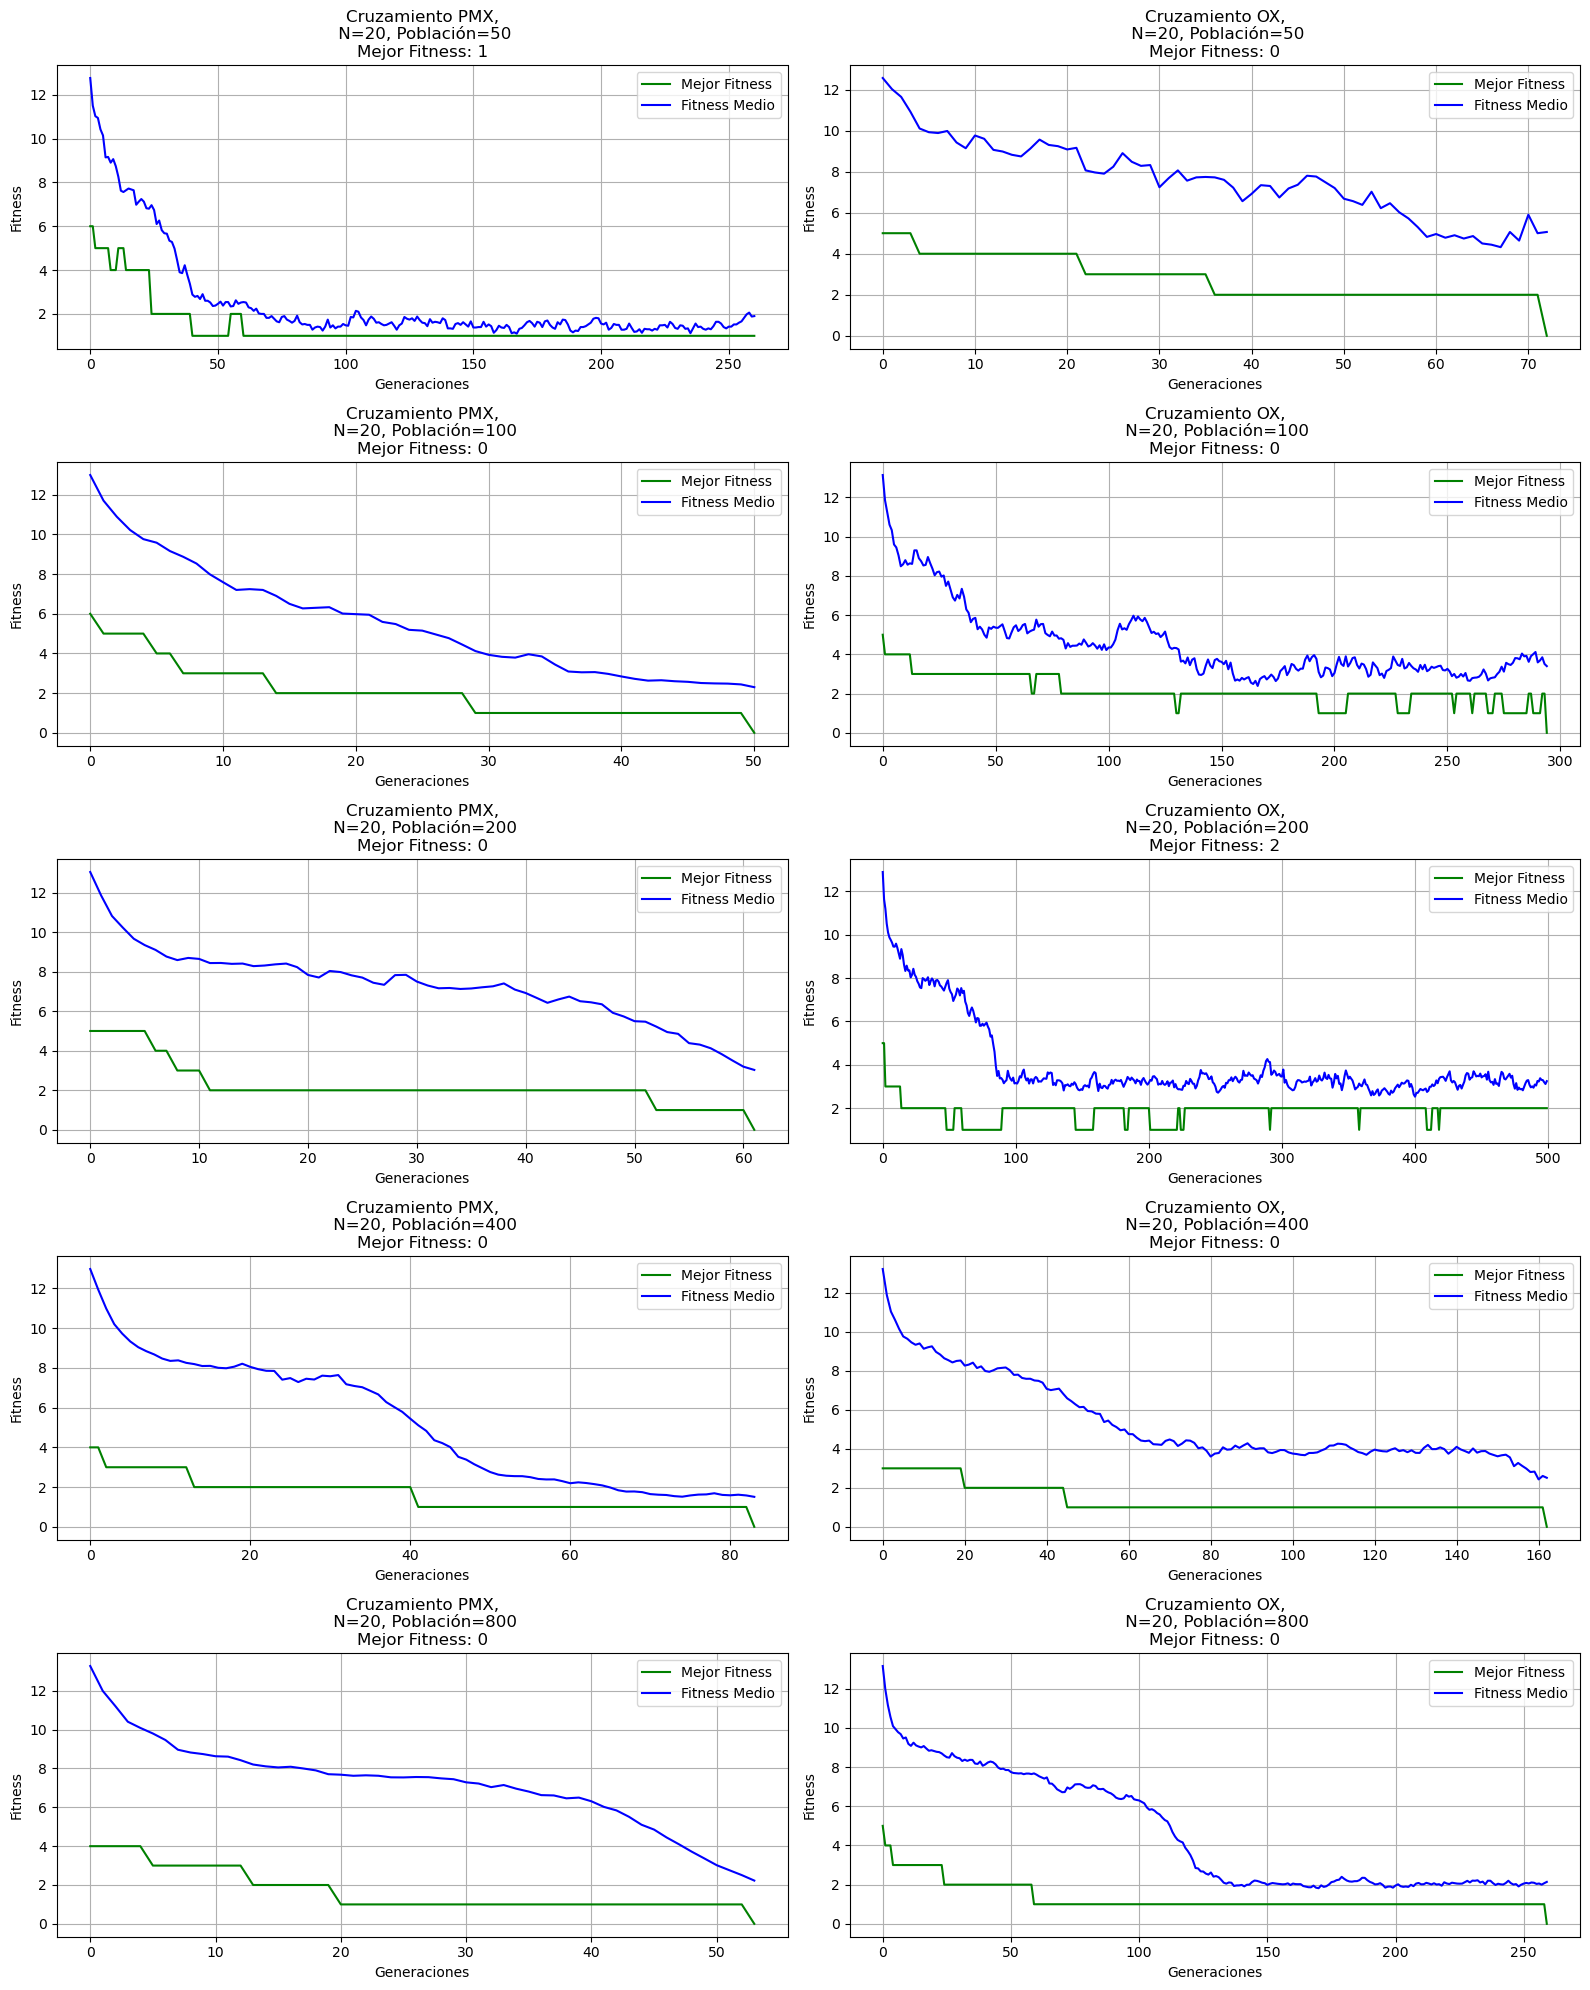

In [64]:
N_reinas = 20
N_poblaciones = [50, 100, 200, 400, 800]

fig, ax = plt.subplots(figsize=(16, 20), ncols=2, nrows=len(N_poblaciones))
column_titles = [
    "Cruzamiento PMX",
    "Cruzamiento OX"
]

for i, N_poblacion in enumerate(N_poblaciones):
    print(f"Realizando pruebas para poblacion={N_poblacion}...")
    mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion = AG(
        N_poblacion=N_poblacion,
        N_cromosoma=N,  
        f_fitness=fitness,
        f_mutacion=mutar_individuo_intercambio,
        f_cruzamiento=cruzar_progenitores_pmx,
        prob_cruz=0.9,
        prob_mut=0.3,
        max_sin_mejoras=200
    )

    titulo = f"{column_titles[0]},\n N={N_reinas}, Población={N_poblacion}\nMejor Fitness: {mejor_fitness}"
    crear_grafico_fitness(mejor_fitness_generacion, fitness_medio_generacion, ax=ax[i, 0], titulo=titulo)

    mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion = AG(
        N_poblacion=N_poblacion,
        N_cromosoma=N,  
        f_fitness=fitness,
        f_mutacion=mutar_individuo_intercambio,
        f_cruzamiento=cruzar_progenitores_ox,
        prob_cruz=0.9,
        prob_mut=0.3,
        max_sin_mejoras=200
    )

    titulo = f"{column_titles[1]},\n N={N_reinas}, Población={N_poblacion}\nMejor Fitness: {mejor_fitness}"
    crear_grafico_fitness(mejor_fitness_generacion, fitness_medio_generacion, ax=ax[i, 1], titulo=titulo)

plt.tight_layout()
plt.show() 

En este caso, el cruzamiento parcialmente mapeado (PMX) muestra un mejor desempeño al evitar la convergencia prematura. A diferencia del cruzamiento por orden (OX), que tiende a quedar atrapado con mayor facilidad en óptimos locales, PMX mantiene una mayor diversidad en la población durante más generaciones, lo que favorece una exploración más efectiva del espacio de soluciones. Esto conlleva a que el algoritmo con PMX converga más rápido.

Por este motivo, se opta por utilizar PMX como operador de cruzamiento en futuras ejecuciones del algoritmo.

## 6. Máximo N resuelto:

Para concluir con el trabajo, trataremos de encontrar cual es el mayor N que puede alcanzar a solucionar nuestro algoritmo genético:

In [ ]:
N_max = 100
N_poblacion = 50
num_iteraciones = 500
num_ejecuciones = 3

for n in range(N_max, N_max + 1, 5):
    mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion = AG(
        N_poblacion=N_poblacion,
        N_cromosoma=n,
        f_fitness=fitness,
        f_mutacion=mutar_individuo_intercambio,
        f_cruzamiento=cruzar_progenitores_pmx,
        prob_cruz=0.9,
        prob_mut=0.3,
        num_iteraciones=num_iteraciones
    )

    print(f"-- {n}-Reinas --")
    print(f"Fitness final: {mejor_fitness}")
    mejor_solucion.mostrar_individuo()
    mostrar_historial_fitness(mejor_fitness_generacion, fitness_medio_generacion)

TypeError: AG() got an unexpected keyword argument 'f_mutacion'

In [ ]:
array = np.array(mejor_solucion.cromosoma)

In [ ]:
np.unique(array).shape

(84,)

In [ ]:
array.shape

(100,)